Using the constrcuted dataset to test out the NIPS debiasing method

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from typing import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import sys
sys.path.append("../lib")

DATA_ROOT = Path("../data")

In [4]:
from bert_utils import Config, BertPreprocessor

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [5]:
train_file = "gender_occ_pos_w_probs_train.txt"
val_file = "gender_occ_pos_w_probs_val.txt"

In [6]:
# Parameters
train_file = "gender_emo_w_probs_train.txt"
val_file = "gender_emo_w_probs_val.txt"


In [7]:
config = Config(
    model_type="bert-base-uncased",
    max_seq_len=24,
    subspace_size=5,
)

In [8]:
processor = BertPreprocessor(config.model_type, config.max_seq_len)

In [9]:
from pytorch_pretrained_bert import BertConfig, BertForMaskedLM
model = BertForMaskedLM.from_pretrained(config.model_type)
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertIntermediate(
       

In [10]:
from dataclasses import dataclass

@dataclass
class ContextWord:
    sent: str
    word: str
    def __post_init__(self):
        assert self.word in self.sent

In [11]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [12]:
def get_word_vector(cword: ContextWord, use_last_mask=False):
    sentence, word = cword.sent, cword.word
    idx = processor.get_index(sentence, word, last=use_last_mask)
    outputs = None
    with torch.no_grad():
        # TODO: Move to proper library function
        token_ids = processor.to_bert_model_input(sentence) 
        # ensure padding is consistent
        bert_input = torch.zeros(1, config.max_seq_len, dtype=torch.long)
        bert_input[0, :token_ids.size(1)] = token_ids
        sequence_output, _ = model.bert(bert_input,
                                        output_all_encoded_layers=False)
        sequence_output.squeeze_(0)
        if outputs is None: outputs = torch.zeros_like(sequence_output)
        outputs = sequence_output + outputs
    return outputs.detach().cpu().numpy()[idx]

In [13]:
def construct_sim_matrix(vecs):
    sim_matrix = np.zeros((len(vecs), len(vecs)))
    for i, v in enumerate(vecs):
        for j, w in enumerate(vecs):
            sim_matrix[i, j] = cosine_similarity(v, w)
    return sim_matrix

In [14]:
def construct_sim_matrix_df(sentences: List[str],
                           words: List[str]):
    sim = construct_sim_matrix([get_word_vector(ContextWord(sent, word)) for sent, word in zip(sentences, words)])
    return pd.DataFrame(data=sim, index=words, columns=words)

In [15]:
def compute_diff_similarity(cwords1, cwords2):
    cword11, cword12 = cwords1
    cword21, cword22 = cwords2
    return cosine_similarity(get_word_vector(cword11) - get_word_vector(cword12),
                             get_word_vector(cword21) - get_word_vector(cword22))

In [16]:
out_softmax = model.cls.predictions.decoder.weight.data.cpu().numpy()

In [17]:
out_bias = model.cls.predictions.bias.data.cpu().numpy()

In [18]:
def to_logits(wv: np.ndarray) -> np.ndarray:
    return model.cls(torch.FloatTensor(wv).unsqueeze(0)).detach().cpu().numpy()[0, :]

# Check similarities

In [19]:
construct_sim_matrix_df(["That person is a programmer.", 
                         "I am a man.", 
                         "I am a woman."],
                       ["programmer", "man", "woman"])

,programmer,man,woman
programmer,1.000000,0.453046,0.488973
man,0.453046,1.000000,0.781821
woman,0.488973,0.781821,1.000000


In [20]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.13653895

In [21]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.20923696

In [22]:
compute_diff_similarity(
    (ContextWord("he likes sports.", "he"), ContextWord("she likes sports.", "she")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.21795174

# Find gendered direction

In [23]:
df_train = pd.read_csv(DATA_ROOT / train_file)

In [24]:
df_val = pd.read_csv(DATA_ROOT / val_file)

In [25]:
from tqdm import tqdm

male_vecs, female_vecs = [], []
def add_word_vecs(s: str, male_w: str, female_w: str):
    male_vecs.append(get_word_vector(ContextWord(s.replace("[MASK]", male_w), male_w)))
    female_vecs.append(get_word_vector(ContextWord(s.replace("[MASK]", female_w), female_w)))

for i, row in tqdm(list(df_train.iterrows())):
    sentence = row["sentence"]
    add_word_vecs(sentence, row["mword"], row["fword"])

  0%|          | 0/864 [00:00<?, ?it/s]

  0%|          | 1/864 [00:00<04:17,  3.35it/s]

  0%|          | 2/864 [00:00<04:19,  3.32it/s]

  0%|          | 3/864 [00:00<04:24,  3.25it/s]

  0%|          | 4/864 [00:01<04:43,  3.03it/s]

  1%|          | 5/864 [00:01<04:51,  2.95it/s]

  1%|          | 6/864 [00:01<04:45,  3.01it/s]

  1%|          | 7/864 [00:02<04:22,  3.26it/s]

  1%|          | 8/864 [00:02<04:08,  3.44it/s]

  1%|          | 9/864 [00:02<04:07,  3.45it/s]

  1%|          | 10/864 [00:03<04:00,  3.54it/s]

  1%|▏         | 11/864 [00:03<03:53,  3.65it/s]

  1%|▏         | 12/864 [00:03<03:58,  3.57it/s]

  2%|▏         | 13/864 [00:03<03:55,  3.61it/s]

  2%|▏         | 14/864 [00:04<03:50,  3.69it/s]

  2%|▏         | 15/864 [00:04<03:53,  3.64it/s]

  2%|▏         | 16/864 [00:04<04:14,  3.33it/s]

  2%|▏         | 17/864 [00:05<04:10,  3.38it/s]

  2%|▏         | 18/864 [00:05<04:25,  3.19it/s]

  2%|▏         | 19/864 [00:05<04:14,  3.32it/s]

  2%|▏         | 20/864 [00:05<04:08,  3.40it/s]

  2%|▏         | 21/864 [00:06<03:59,  3.52it/s]

  3%|▎         | 22/864 [00:06<04:02,  3.48it/s]

  3%|▎         | 23/864 [00:06<04:26,  3.16it/s]

  3%|▎         | 24/864 [00:07<04:21,  3.22it/s]

  3%|▎         | 25/864 [00:07<04:29,  3.11it/s]

  3%|▎         | 26/864 [00:07<04:16,  3.27it/s]

  3%|▎         | 27/864 [00:08<04:10,  3.34it/s]

  3%|▎         | 28/864 [00:08<04:03,  3.44it/s]

  3%|▎         | 29/864 [00:08<04:39,  2.98it/s]

  3%|▎         | 30/864 [00:09<04:44,  2.93it/s]

  4%|▎         | 31/864 [00:09<04:35,  3.03it/s]

  4%|▎         | 32/864 [00:09<04:07,  3.36it/s]

  4%|▍         | 33/864 [00:10<04:13,  3.28it/s]

  4%|▍         | 34/864 [00:10<04:29,  3.08it/s]

  4%|▍         | 35/864 [00:10<04:35,  3.01it/s]

  4%|▍         | 36/864 [00:11<04:32,  3.04it/s]

  4%|▍         | 37/864 [00:11<04:45,  2.89it/s]

  4%|▍         | 38/864 [00:11<04:27,  3.08it/s]

  5%|▍         | 39/864 [00:11<04:12,  3.27it/s]

  5%|▍         | 40/864 [00:12<04:05,  3.36it/s]

  5%|▍         | 41/864 [00:12<04:01,  3.41it/s]

  5%|▍         | 42/864 [00:12<04:15,  3.22it/s]

  5%|▍         | 43/864 [00:13<04:24,  3.10it/s]

  5%|▌         | 44/864 [00:13<04:35,  2.98it/s]

  5%|▌         | 45/864 [00:13<04:29,  3.04it/s]

  5%|▌         | 46/864 [00:14<04:21,  3.13it/s]

  5%|▌         | 47/864 [00:14<04:08,  3.29it/s]

  6%|▌         | 48/864 [00:14<04:04,  3.34it/s]

  6%|▌         | 49/864 [00:15<04:28,  3.04it/s]

  6%|▌         | 50/864 [00:15<04:38,  2.93it/s]

  6%|▌         | 51/864 [00:15<04:43,  2.87it/s]

  6%|▌         | 52/864 [00:16<04:35,  2.95it/s]

  6%|▌         | 53/864 [00:16<04:24,  3.06it/s]

  6%|▋         | 54/864 [00:16<04:11,  3.22it/s]

  6%|▋         | 55/864 [00:17<03:47,  3.55it/s]

  6%|▋         | 56/864 [00:17<03:39,  3.68it/s]

  7%|▋         | 57/864 [00:17<03:36,  3.74it/s]

  7%|▋         | 58/864 [00:17<03:28,  3.87it/s]

  7%|▋         | 59/864 [00:17<03:25,  3.91it/s]

  7%|▋         | 60/864 [00:18<03:23,  3.95it/s]

  7%|▋         | 61/864 [00:18<03:31,  3.79it/s]

  7%|▋         | 62/864 [00:18<03:41,  3.63it/s]

  7%|▋         | 63/864 [00:19<03:31,  3.78it/s]

  7%|▋         | 64/864 [00:19<03:31,  3.78it/s]

  8%|▊         | 65/864 [00:19<03:25,  3.89it/s]

  8%|▊         | 66/864 [00:19<03:22,  3.94it/s]

  8%|▊         | 67/864 [00:20<03:29,  3.80it/s]

  8%|▊         | 68/864 [00:20<03:35,  3.70it/s]

  8%|▊         | 69/864 [00:20<03:41,  3.59it/s]

  8%|▊         | 70/864 [00:21<04:01,  3.28it/s]

  8%|▊         | 71/864 [00:21<04:04,  3.24it/s]

  8%|▊         | 72/864 [00:21<03:54,  3.38it/s]

  8%|▊         | 73/864 [00:21<03:51,  3.42it/s]

  9%|▊         | 74/864 [00:22<03:45,  3.51it/s]

  9%|▊         | 75/864 [00:22<03:40,  3.58it/s]

  9%|▉         | 76/864 [00:22<03:43,  3.52it/s]

  9%|▉         | 77/864 [00:23<04:01,  3.26it/s]

  9%|▉         | 78/864 [00:23<03:43,  3.51it/s]

  9%|▉         | 79/864 [00:23<03:59,  3.27it/s]

  9%|▉         | 80/864 [00:23<03:53,  3.35it/s]

  9%|▉         | 81/864 [00:24<03:41,  3.54it/s]

  9%|▉         | 82/864 [00:24<03:40,  3.55it/s]

 10%|▉         | 83/864 [00:24<03:59,  3.26it/s]

 10%|▉         | 84/864 [00:25<04:12,  3.09it/s]

 10%|▉         | 85/864 [00:25<04:03,  3.20it/s]

 10%|▉         | 86/864 [00:25<03:55,  3.30it/s]

 10%|█         | 87/864 [00:26<03:51,  3.36it/s]

 10%|█         | 88/864 [00:26<03:54,  3.31it/s]

 10%|█         | 89/864 [00:26<04:39,  2.77it/s]

 10%|█         | 90/864 [00:27<04:38,  2.78it/s]

 11%|█         | 91/864 [00:27<04:16,  3.01it/s]

 11%|█         | 92/864 [00:27<04:04,  3.16it/s]

 11%|█         | 93/864 [00:28<03:53,  3.31it/s]

 11%|█         | 94/864 [00:28<04:17,  2.99it/s]

 11%|█         | 95/864 [00:28<04:30,  2.84it/s]

 11%|█         | 96/864 [00:29<04:08,  3.08it/s]

 11%|█         | 97/864 [00:29<03:54,  3.27it/s]

 11%|█▏        | 98/864 [00:29<03:43,  3.43it/s]

 11%|█▏        | 99/864 [00:30<03:58,  3.20it/s]

 12%|█▏        | 100/864 [00:30<04:12,  3.02it/s]

 12%|█▏        | 101/864 [00:30<04:21,  2.92it/s]

 12%|█▏        | 102/864 [00:31<04:22,  2.90it/s]

 12%|█▏        | 103/864 [00:31<04:05,  3.10it/s]

 12%|█▏        | 104/864 [00:31<04:20,  2.92it/s]

 12%|█▏        | 105/864 [00:32<04:01,  3.15it/s]

 12%|█▏        | 106/864 [00:32<03:53,  3.24it/s]

 12%|█▏        | 107/864 [00:32<03:58,  3.17it/s]

 12%|█▎        | 108/864 [00:32<03:57,  3.18it/s]

 13%|█▎        | 109/864 [00:33<03:46,  3.34it/s]

 13%|█▎        | 110/864 [00:33<03:34,  3.51it/s]

 13%|█▎        | 111/864 [00:33<03:29,  3.59it/s]

 13%|█▎        | 112/864 [00:33<03:24,  3.67it/s]

 13%|█▎        | 113/864 [00:34<03:31,  3.55it/s]

 13%|█▎        | 114/864 [00:34<03:39,  3.42it/s]

 13%|█▎        | 115/864 [00:34<03:43,  3.36it/s]

 13%|█▎        | 116/864 [00:35<03:38,  3.42it/s]

 14%|█▎        | 117/864 [00:35<03:51,  3.22it/s]

 14%|█▎        | 118/864 [00:35<04:01,  3.09it/s]

 14%|█▍        | 119/864 [00:36<03:51,  3.21it/s]

 14%|█▍        | 120/864 [00:36<03:58,  3.12it/s]

 14%|█▍        | 121/864 [00:36<04:15,  2.91it/s]

 14%|█▍        | 122/864 [00:37<03:54,  3.17it/s]

 14%|█▍        | 123/864 [00:37<03:42,  3.33it/s]

 14%|█▍        | 124/864 [00:37<04:01,  3.06it/s]

 14%|█▍        | 125/864 [00:38<03:58,  3.09it/s]

 15%|█▍        | 126/864 [00:38<03:54,  3.14it/s]

 15%|█▍        | 127/864 [00:38<04:15,  2.88it/s]

 15%|█▍        | 128/864 [00:39<03:59,  3.08it/s]

 15%|█▍        | 129/864 [00:39<04:18,  2.84it/s]

 15%|█▌        | 130/864 [00:39<04:02,  3.02it/s]

 15%|█▌        | 131/864 [00:40<04:12,  2.90it/s]

 15%|█▌        | 132/864 [00:40<04:14,  2.88it/s]

 15%|█▌        | 133/864 [00:40<04:08,  2.94it/s]

 16%|█▌        | 134/864 [00:41<04:00,  3.04it/s]

 16%|█▌        | 135/864 [00:41<04:06,  2.96it/s]

 16%|█▌        | 136/864 [00:41<04:10,  2.91it/s]

 16%|█▌        | 137/864 [00:42<04:03,  2.99it/s]

 16%|█▌        | 138/864 [00:42<04:25,  2.74it/s]

 16%|█▌        | 139/864 [00:43<04:29,  2.69it/s]

 16%|█▌        | 140/864 [00:43<04:21,  2.77it/s]

 16%|█▋        | 141/864 [00:43<04:19,  2.79it/s]

 16%|█▋        | 142/864 [00:44<04:11,  2.87it/s]

 17%|█▋        | 143/864 [00:44<03:54,  3.07it/s]

 17%|█▋        | 144/864 [00:44<03:41,  3.24it/s]

 17%|█▋        | 145/864 [00:44<03:33,  3.37it/s]

 17%|█▋        | 146/864 [00:45<03:25,  3.50it/s]

 17%|█▋        | 147/864 [00:45<03:23,  3.52it/s]

 17%|█▋        | 148/864 [00:45<03:19,  3.58it/s]

 17%|█▋        | 149/864 [00:45<03:24,  3.49it/s]

 17%|█▋        | 150/864 [00:46<04:14,  2.80it/s]

 17%|█▋        | 151/864 [00:46<04:17,  2.77it/s]

 18%|█▊        | 152/864 [00:47<04:21,  2.72it/s]

 18%|█▊        | 153/864 [00:47<04:32,  2.60it/s]

 18%|█▊        | 154/864 [00:47<04:16,  2.77it/s]

 18%|█▊        | 155/864 [00:48<04:41,  2.52it/s]

 18%|█▊        | 156/864 [00:48<04:55,  2.40it/s]

 18%|█▊        | 157/864 [00:49<04:44,  2.48it/s]

 18%|█▊        | 158/864 [00:49<04:31,  2.60it/s]

 18%|█▊        | 159/864 [00:50<04:22,  2.68it/s]

 19%|█▊        | 160/864 [00:50<04:38,  2.53it/s]

 19%|█▊        | 161/864 [00:50<04:22,  2.67it/s]

 19%|█▉        | 162/864 [00:51<04:24,  2.66it/s]

 19%|█▉        | 163/864 [00:51<04:34,  2.55it/s]

 19%|█▉        | 164/864 [00:51<04:13,  2.76it/s]

 19%|█▉        | 165/864 [00:52<04:35,  2.53it/s]

 19%|█▉        | 166/864 [00:52<04:25,  2.63it/s]

 19%|█▉        | 167/864 [00:53<04:19,  2.69it/s]

 19%|█▉        | 168/864 [00:53<04:06,  2.82it/s]

 20%|█▉        | 169/864 [00:53<04:00,  2.89it/s]

 20%|█▉        | 170/864 [00:53<03:48,  3.04it/s]

 20%|█▉        | 171/864 [00:54<03:53,  2.96it/s]

 20%|█▉        | 172/864 [00:54<03:51,  2.99it/s]

 20%|██        | 173/864 [00:55<03:55,  2.94it/s]

 20%|██        | 174/864 [00:55<03:48,  3.01it/s]

 20%|██        | 175/864 [00:55<04:03,  2.83it/s]

 20%|██        | 176/864 [00:56<03:57,  2.89it/s]

 20%|██        | 177/864 [00:56<03:54,  2.94it/s]

 21%|██        | 178/864 [00:56<04:00,  2.85it/s]

 21%|██        | 179/864 [00:57<04:22,  2.61it/s]

 21%|██        | 180/864 [00:57<04:03,  2.81it/s]

 21%|██        | 181/864 [00:57<03:45,  3.03it/s]

 21%|██        | 182/864 [00:58<03:28,  3.27it/s]

 21%|██        | 183/864 [00:58<03:19,  3.42it/s]

 21%|██▏       | 184/864 [00:58<03:16,  3.47it/s]

 21%|██▏       | 185/864 [00:58<03:06,  3.63it/s]

 22%|██▏       | 186/864 [00:59<03:02,  3.71it/s]

 22%|██▏       | 187/864 [00:59<02:58,  3.79it/s]

 22%|██▏       | 188/864 [00:59<03:00,  3.76it/s]

 22%|██▏       | 189/864 [00:59<02:59,  3.76it/s]

 22%|██▏       | 190/864 [01:00<03:11,  3.52it/s]

 22%|██▏       | 191/864 [01:00<03:09,  3.55it/s]

 22%|██▏       | 192/864 [01:00<03:10,  3.52it/s]

 22%|██▏       | 193/864 [01:01<03:16,  3.42it/s]

 22%|██▏       | 194/864 [01:01<03:18,  3.37it/s]

 23%|██▎       | 195/864 [01:01<03:16,  3.41it/s]

 23%|██▎       | 196/864 [01:01<03:12,  3.48it/s]

 23%|██▎       | 197/864 [01:02<03:18,  3.36it/s]

 23%|██▎       | 198/864 [01:02<03:34,  3.11it/s]

 23%|██▎       | 199/864 [01:03<03:46,  2.93it/s]

 23%|██▎       | 200/864 [01:03<03:44,  2.96it/s]

 23%|██▎       | 201/864 [01:03<03:45,  2.94it/s]

 23%|██▎       | 202/864 [01:04<03:46,  2.93it/s]

 23%|██▎       | 203/864 [01:04<03:45,  2.94it/s]

 24%|██▎       | 204/864 [01:04<03:36,  3.05it/s]

 24%|██▎       | 205/864 [01:05<03:36,  3.04it/s]

 24%|██▍       | 206/864 [01:05<04:01,  2.72it/s]

 24%|██▍       | 207/864 [01:05<04:09,  2.63it/s]

 24%|██▍       | 208/864 [01:06<04:27,  2.45it/s]

 24%|██▍       | 209/864 [01:06<04:32,  2.40it/s]

 24%|██▍       | 210/864 [01:07<04:11,  2.60it/s]

 24%|██▍       | 211/864 [01:07<04:02,  2.69it/s]

 25%|██▍       | 212/864 [01:07<03:58,  2.73it/s]

 25%|██▍       | 213/864 [01:08<04:03,  2.67it/s]

 25%|██▍       | 214/864 [01:08<03:57,  2.74it/s]

 25%|██▍       | 215/864 [01:08<03:44,  2.89it/s]

 25%|██▌       | 216/864 [01:09<03:46,  2.86it/s]

 25%|██▌       | 217/864 [01:09<03:45,  2.87it/s]

 25%|██▌       | 218/864 [01:09<03:35,  2.99it/s]

 25%|██▌       | 219/864 [01:10<03:29,  3.08it/s]

 25%|██▌       | 220/864 [01:10<03:43,  2.88it/s]

 26%|██▌       | 221/864 [01:10<04:02,  2.65it/s]

 26%|██▌       | 222/864 [01:11<04:02,  2.65it/s]

 26%|██▌       | 223/864 [01:11<03:53,  2.75it/s]

 26%|██▌       | 224/864 [01:12<03:45,  2.83it/s]

 26%|██▌       | 225/864 [01:12<03:34,  2.98it/s]

 26%|██▌       | 226/864 [01:12<03:18,  3.22it/s]

 26%|██▋       | 227/864 [01:12<03:18,  3.21it/s]

 26%|██▋       | 228/864 [01:13<03:17,  3.22it/s]

 27%|██▋       | 229/864 [01:13<03:06,  3.40it/s]

 27%|██▋       | 230/864 [01:13<03:00,  3.51it/s]

 27%|██▋       | 231/864 [01:13<02:56,  3.58it/s]

 27%|██▋       | 232/864 [01:14<02:57,  3.57it/s]

 27%|██▋       | 233/864 [01:14<02:55,  3.60it/s]

 27%|██▋       | 234/864 [01:14<02:50,  3.69it/s]

 27%|██▋       | 235/864 [01:15<03:02,  3.44it/s]

 27%|██▋       | 236/864 [01:15<02:57,  3.54it/s]

 27%|██▋       | 237/864 [01:15<03:00,  3.48it/s]

 28%|██▊       | 238/864 [01:15<02:58,  3.50it/s]

 28%|██▊       | 239/864 [01:16<02:59,  3.47it/s]

 28%|██▊       | 240/864 [01:16<03:07,  3.32it/s]

 28%|██▊       | 241/864 [01:16<03:04,  3.38it/s]

 28%|██▊       | 242/864 [01:17<03:06,  3.33it/s]

 28%|██▊       | 243/864 [01:17<03:09,  3.27it/s]

 28%|██▊       | 244/864 [01:17<03:24,  3.04it/s]

 28%|██▊       | 245/864 [01:18<03:18,  3.12it/s]

 28%|██▊       | 246/864 [01:18<03:20,  3.08it/s]

 29%|██▊       | 247/864 [01:18<03:22,  3.05it/s]

 29%|██▊       | 248/864 [01:19<03:25,  3.00it/s]

 29%|██▉       | 249/864 [01:19<03:25,  3.00it/s]

 29%|██▉       | 250/864 [01:19<03:30,  2.91it/s]

 29%|██▉       | 251/864 [01:20<03:25,  2.98it/s]

 29%|██▉       | 252/864 [01:20<03:19,  3.07it/s]

 29%|██▉       | 253/864 [01:21<05:28,  1.86it/s]

 29%|██▉       | 254/864 [01:22<05:56,  1.71it/s]

 30%|██▉       | 255/864 [01:22<05:26,  1.87it/s]

 30%|██▉       | 256/864 [01:23<04:57,  2.04it/s]

 30%|██▉       | 257/864 [01:23<04:34,  2.21it/s]

 30%|██▉       | 258/864 [01:23<04:15,  2.37it/s]

 30%|██▉       | 259/864 [01:24<04:04,  2.47it/s]

 30%|███       | 260/864 [01:24<03:56,  2.56it/s]

 30%|███       | 261/864 [01:24<03:47,  2.65it/s]

 30%|███       | 262/864 [01:25<03:41,  2.72it/s]

 30%|███       | 263/864 [01:25<03:54,  2.56it/s]

 31%|███       | 264/864 [01:25<03:43,  2.68it/s]

 31%|███       | 265/864 [01:26<03:31,  2.84it/s]

 31%|███       | 266/864 [01:26<03:23,  2.93it/s]

 31%|███       | 267/864 [01:26<03:14,  3.07it/s]

 31%|███       | 268/864 [01:27<03:14,  3.07it/s]

 31%|███       | 269/864 [01:27<03:03,  3.24it/s]

 31%|███▏      | 270/864 [01:27<03:07,  3.16it/s]

 31%|███▏      | 271/864 [01:28<03:08,  3.15it/s]

 31%|███▏      | 272/864 [01:28<03:06,  3.17it/s]

 32%|███▏      | 273/864 [01:28<02:59,  3.29it/s]

 32%|███▏      | 274/864 [01:28<02:59,  3.28it/s]

 32%|███▏      | 275/864 [01:29<03:00,  3.26it/s]

 32%|███▏      | 276/864 [01:29<02:51,  3.43it/s]

 32%|███▏      | 277/864 [01:29<02:43,  3.59it/s]

 32%|███▏      | 278/864 [01:30<02:41,  3.63it/s]

 32%|███▏      | 279/864 [01:30<02:36,  3.74it/s]

 32%|███▏      | 280/864 [01:30<02:31,  3.85it/s]

 33%|███▎      | 281/864 [01:30<02:34,  3.78it/s]

 33%|███▎      | 282/864 [01:31<02:34,  3.78it/s]

 33%|███▎      | 283/864 [01:31<02:49,  3.43it/s]

 33%|███▎      | 284/864 [01:31<02:48,  3.44it/s]

 33%|███▎      | 285/864 [01:32<03:11,  3.02it/s]

 33%|███▎      | 286/864 [01:32<03:07,  3.08it/s]

 33%|███▎      | 287/864 [01:32<02:57,  3.25it/s]

 33%|███▎      | 288/864 [01:33<03:13,  2.98it/s]

 33%|███▎      | 289/864 [01:33<03:24,  2.81it/s]

 34%|███▎      | 290/864 [01:33<03:13,  2.96it/s]

 34%|███▎      | 291/864 [01:34<03:06,  3.07it/s]

 34%|███▍      | 292/864 [01:34<03:08,  3.03it/s]

 34%|███▍      | 293/864 [01:34<03:08,  3.03it/s]

 34%|███▍      | 294/864 [01:35<03:25,  2.77it/s]

 34%|███▍      | 295/864 [01:35<03:19,  2.85it/s]

 34%|███▍      | 296/864 [01:36<03:35,  2.64it/s]

 34%|███▍      | 297/864 [01:36<03:54,  2.42it/s]

 34%|███▍      | 298/864 [01:36<03:48,  2.48it/s]

 35%|███▍      | 299/864 [01:37<04:01,  2.34it/s]

 35%|███▍      | 300/864 [01:37<03:49,  2.45it/s]

 35%|███▍      | 301/864 [01:38<03:40,  2.55it/s]

 35%|███▍      | 302/864 [01:38<03:39,  2.56it/s]

 35%|███▌      | 303/864 [01:38<03:34,  2.62it/s]

 35%|███▌      | 304/864 [01:39<03:49,  2.44it/s]

 35%|███▌      | 305/864 [01:39<03:35,  2.59it/s]

 35%|███▌      | 306/864 [01:39<03:17,  2.82it/s]

 36%|███▌      | 307/864 [01:40<03:11,  2.92it/s]

 36%|███▌      | 308/864 [01:40<03:03,  3.03it/s]

 36%|███▌      | 309/864 [01:40<03:05,  2.98it/s]

 36%|███▌      | 310/864 [01:41<03:01,  3.05it/s]

 36%|███▌      | 311/864 [01:41<02:58,  3.10it/s]

 36%|███▌      | 312/864 [01:41<02:48,  3.28it/s]

 36%|███▌      | 313/864 [01:42<02:36,  3.52it/s]

 36%|███▋      | 314/864 [01:42<02:36,  3.51it/s]

 36%|███▋      | 315/864 [01:42<02:34,  3.56it/s]

 37%|███▋      | 316/864 [01:42<02:33,  3.57it/s]

 37%|███▋      | 317/864 [01:43<02:41,  3.40it/s]

 37%|███▋      | 318/864 [01:43<02:40,  3.41it/s]

 37%|███▋      | 319/864 [01:43<02:31,  3.59it/s]

 37%|███▋      | 320/864 [01:43<02:26,  3.71it/s]

 37%|███▋      | 321/864 [01:44<02:21,  3.85it/s]

 37%|███▋      | 322/864 [01:44<02:46,  3.26it/s]

 37%|███▋      | 323/864 [01:44<02:48,  3.22it/s]

 38%|███▊      | 324/864 [01:45<02:50,  3.17it/s]

 38%|███▊      | 325/864 [01:45<02:39,  3.37it/s]

 38%|███▊      | 326/864 [01:45<02:31,  3.54it/s]

 38%|███▊      | 327/864 [01:46<02:25,  3.70it/s]

 38%|███▊      | 328/864 [01:46<02:28,  3.60it/s]

 38%|███▊      | 329/864 [01:46<02:29,  3.59it/s]

 38%|███▊      | 330/864 [01:46<02:27,  3.61it/s]

 38%|███▊      | 331/864 [01:47<02:51,  3.11it/s]

 38%|███▊      | 332/864 [01:47<02:45,  3.21it/s]

 39%|███▊      | 333/864 [01:47<02:42,  3.27it/s]

 39%|███▊      | 334/864 [01:48<02:45,  3.20it/s]

 39%|███▉      | 335/864 [01:48<02:52,  3.07it/s]

 39%|███▉      | 336/864 [01:48<02:46,  3.17it/s]

 39%|███▉      | 337/864 [01:49<03:07,  2.82it/s]

 39%|███▉      | 338/864 [01:49<03:00,  2.91it/s]

 39%|███▉      | 339/864 [01:49<03:03,  2.86it/s]

 39%|███▉      | 340/864 [01:50<02:53,  3.03it/s]

 39%|███▉      | 341/864 [01:50<02:38,  3.31it/s]

 40%|███▉      | 342/864 [01:50<02:42,  3.22it/s]

 40%|███▉      | 343/864 [01:51<03:01,  2.86it/s]

 40%|███▉      | 344/864 [01:51<02:51,  3.03it/s]

 40%|███▉      | 345/864 [01:51<02:45,  3.14it/s]

 40%|████      | 346/864 [01:52<02:41,  3.20it/s]

 40%|████      | 347/864 [01:52<02:45,  3.13it/s]

 40%|████      | 348/864 [01:52<02:48,  3.06it/s]

 40%|████      | 349/864 [01:53<03:05,  2.78it/s]

 41%|████      | 350/864 [01:53<02:55,  2.92it/s]

 41%|████      | 351/864 [01:53<02:49,  3.02it/s]

 41%|████      | 352/864 [01:54<02:44,  3.11it/s]

 41%|████      | 353/864 [01:54<02:44,  3.11it/s]

 41%|████      | 354/864 [01:54<02:41,  3.15it/s]

 41%|████      | 355/864 [01:55<02:49,  3.00it/s]

 41%|████      | 356/864 [01:55<02:48,  3.02it/s]

 41%|████▏     | 357/864 [01:55<02:47,  3.03it/s]

 41%|████▏     | 358/864 [01:56<02:48,  3.00it/s]

 42%|████▏     | 359/864 [01:56<02:43,  3.09it/s]

 42%|████▏     | 360/864 [01:56<02:39,  3.15it/s]

 42%|████▏     | 361/864 [01:57<02:33,  3.27it/s]

 42%|████▏     | 362/864 [01:57<02:44,  3.05it/s]

 42%|████▏     | 363/864 [01:57<02:39,  3.14it/s]

 42%|████▏     | 364/864 [01:57<02:31,  3.30it/s]

 42%|████▏     | 365/864 [01:58<02:25,  3.43it/s]

 42%|████▏     | 366/864 [01:58<02:22,  3.50it/s]

 42%|████▏     | 367/864 [01:58<02:25,  3.41it/s]

 43%|████▎     | 368/864 [01:59<02:23,  3.46it/s]

 43%|████▎     | 369/864 [01:59<02:26,  3.39it/s]

 43%|████▎     | 370/864 [01:59<02:25,  3.40it/s]

 43%|████▎     | 371/864 [01:59<02:20,  3.50it/s]

 43%|████▎     | 372/864 [02:00<02:21,  3.48it/s]

 43%|████▎     | 373/864 [02:00<02:21,  3.48it/s]

 43%|████▎     | 374/864 [02:00<02:18,  3.53it/s]

 43%|████▎     | 375/864 [02:01<02:27,  3.31it/s]

 44%|████▎     | 376/864 [02:01<02:31,  3.22it/s]

 44%|████▎     | 377/864 [02:01<02:32,  3.20it/s]

 44%|████▍     | 378/864 [02:02<02:34,  3.14it/s]

 44%|████▍     | 379/864 [02:02<02:38,  3.06it/s]

 44%|████▍     | 380/864 [02:02<02:52,  2.81it/s]

 44%|████▍     | 381/864 [02:03<03:00,  2.67it/s]

 44%|████▍     | 382/864 [02:03<03:01,  2.65it/s]

 44%|████▍     | 383/864 [02:04<03:10,  2.53it/s]

 44%|████▍     | 384/864 [02:04<02:49,  2.84it/s]

 45%|████▍     | 385/864 [02:04<02:32,  3.13it/s]

 45%|████▍     | 386/864 [02:05<02:51,  2.79it/s]

 45%|████▍     | 387/864 [02:05<03:04,  2.59it/s]

 45%|████▍     | 388/864 [02:05<03:01,  2.62it/s]

 45%|████▌     | 389/864 [02:06<02:55,  2.70it/s]

 45%|████▌     | 390/864 [02:06<02:50,  2.79it/s]

 45%|████▌     | 391/864 [02:07<02:58,  2.65it/s]

 45%|████▌     | 392/864 [02:07<03:00,  2.61it/s]

 45%|████▌     | 393/864 [02:07<02:49,  2.77it/s]

 46%|████▌     | 394/864 [02:08<02:40,  2.93it/s]

 46%|████▌     | 395/864 [02:08<02:37,  2.98it/s]

 46%|████▌     | 396/864 [02:08<02:29,  3.14it/s]

 46%|████▌     | 397/864 [02:08<02:23,  3.25it/s]

 46%|████▌     | 398/864 [02:09<02:29,  3.13it/s]

 46%|████▌     | 399/864 [02:09<02:28,  3.13it/s]

 46%|████▋     | 400/864 [02:09<02:25,  3.19it/s]

 46%|████▋     | 401/864 [02:10<02:21,  3.28it/s]

 47%|████▋     | 402/864 [02:10<02:15,  3.40it/s]

 47%|████▋     | 403/864 [02:10<02:06,  3.65it/s]

 47%|████▋     | 404/864 [02:10<02:01,  3.78it/s]

 47%|████▋     | 405/864 [02:11<01:58,  3.86it/s]

 47%|████▋     | 406/864 [02:11<01:59,  3.82it/s]

 47%|████▋     | 407/864 [02:11<01:57,  3.89it/s]

 47%|████▋     | 408/864 [02:11<01:53,  4.01it/s]

 47%|████▋     | 409/864 [02:12<01:51,  4.08it/s]

 47%|████▋     | 410/864 [02:12<01:49,  4.13it/s]

 48%|████▊     | 411/864 [02:12<01:46,  4.25it/s]

 48%|████▊     | 412/864 [02:12<01:43,  4.36it/s]

 48%|████▊     | 413/864 [02:13<01:47,  4.21it/s]

 48%|████▊     | 414/864 [02:13<01:52,  4.01it/s]

 48%|████▊     | 415/864 [02:13<01:53,  3.97it/s]

 48%|████▊     | 416/864 [02:13<01:54,  3.92it/s]

 48%|████▊     | 417/864 [02:14<01:52,  3.97it/s]

 48%|████▊     | 418/864 [02:14<01:49,  4.08it/s]

 48%|████▊     | 419/864 [02:14<01:50,  4.03it/s]

 49%|████▊     | 420/864 [02:14<01:50,  4.02it/s]

 49%|████▊     | 421/864 [02:15<01:52,  3.94it/s]

 49%|████▉     | 422/864 [02:15<01:57,  3.75it/s]

 49%|████▉     | 423/864 [02:15<02:03,  3.58it/s]

 49%|████▉     | 424/864 [02:15<02:04,  3.54it/s]

 49%|████▉     | 425/864 [02:16<02:09,  3.38it/s]

 49%|████▉     | 426/864 [02:16<02:20,  3.12it/s]

 49%|████▉     | 427/864 [02:16<02:12,  3.30it/s]

 50%|████▉     | 428/864 [02:17<02:16,  3.21it/s]

 50%|████▉     | 429/864 [02:17<02:09,  3.37it/s]

 50%|████▉     | 430/864 [02:17<02:09,  3.35it/s]

 50%|████▉     | 431/864 [02:18<01:59,  3.63it/s]

 50%|█████     | 432/864 [02:18<01:53,  3.82it/s]

 50%|█████     | 433/864 [02:18<02:19,  3.09it/s]

 50%|█████     | 434/864 [02:19<02:11,  3.28it/s]

 50%|█████     | 435/864 [02:19<02:07,  3.37it/s]

 50%|█████     | 436/864 [02:19<02:04,  3.43it/s]

 51%|█████     | 437/864 [02:19<02:02,  3.48it/s]

 51%|█████     | 438/864 [02:20<01:59,  3.57it/s]

 51%|█████     | 439/864 [02:20<02:14,  3.17it/s]

 51%|█████     | 440/864 [02:20<02:07,  3.32it/s]

 51%|█████     | 441/864 [02:21<02:01,  3.47it/s]

 51%|█████     | 442/864 [02:21<01:58,  3.56it/s]

 51%|█████▏    | 443/864 [02:21<01:57,  3.58it/s]

 51%|█████▏    | 444/864 [02:21<01:56,  3.62it/s]

 52%|█████▏    | 445/864 [02:22<01:53,  3.70it/s]

 52%|█████▏    | 446/864 [02:22<02:03,  3.37it/s]

 52%|█████▏    | 447/864 [02:22<02:00,  3.46it/s]

 52%|█████▏    | 448/864 [02:23<01:55,  3.60it/s]

 52%|█████▏    | 449/864 [02:23<01:53,  3.67it/s]

 52%|█████▏    | 450/864 [02:23<01:49,  3.80it/s]

 52%|█████▏    | 451/864 [02:23<01:47,  3.83it/s]

 52%|█████▏    | 452/864 [02:24<01:45,  3.90it/s]

 52%|█████▏    | 453/864 [02:24<01:42,  4.02it/s]

 53%|█████▎    | 454/864 [02:24<01:41,  4.05it/s]

 53%|█████▎    | 455/864 [02:24<01:39,  4.10it/s]

 53%|█████▎    | 456/864 [02:24<01:37,  4.17it/s]

 53%|█████▎    | 457/864 [02:25<01:40,  4.07it/s]

 53%|█████▎    | 458/864 [02:25<01:45,  3.86it/s]

 53%|█████▎    | 459/864 [02:25<01:39,  4.07it/s]

 53%|█████▎    | 460/864 [02:25<01:39,  4.04it/s]

 53%|█████▎    | 461/864 [02:26<01:37,  4.15it/s]

 53%|█████▎    | 462/864 [02:26<01:32,  4.37it/s]

 54%|█████▎    | 463/864 [02:26<01:30,  4.44it/s]

 54%|█████▎    | 464/864 [02:26<01:28,  4.52it/s]

 54%|█████▍    | 465/864 [02:27<01:29,  4.45it/s]

 54%|█████▍    | 466/864 [02:27<01:36,  4.12it/s]

 54%|█████▍    | 467/864 [02:27<01:36,  4.13it/s]

 54%|█████▍    | 468/864 [02:27<01:34,  4.18it/s]

 54%|█████▍    | 469/864 [02:28<01:32,  4.26it/s]

 54%|█████▍    | 470/864 [02:28<01:31,  4.30it/s]

 55%|█████▍    | 471/864 [02:28<01:32,  4.23it/s]

 55%|█████▍    | 472/864 [02:28<01:34,  4.16it/s]

 55%|█████▍    | 473/864 [02:29<01:35,  4.09it/s]

 55%|█████▍    | 474/864 [02:29<01:35,  4.06it/s]

 55%|█████▍    | 475/864 [02:29<01:32,  4.19it/s]

 55%|█████▌    | 476/864 [02:29<01:32,  4.18it/s]

 55%|█████▌    | 477/864 [02:29<01:31,  4.21it/s]

 55%|█████▌    | 478/864 [02:30<01:31,  4.22it/s]

 55%|█████▌    | 479/864 [02:30<01:36,  3.99it/s]

 56%|█████▌    | 480/864 [02:30<01:45,  3.64it/s]

 56%|█████▌    | 481/864 [02:31<01:43,  3.68it/s]

 56%|█████▌    | 482/864 [02:31<01:53,  3.38it/s]

 56%|█████▌    | 483/864 [02:31<01:50,  3.46it/s]

 56%|█████▌    | 484/864 [02:31<01:45,  3.62it/s]

 56%|█████▌    | 485/864 [02:32<01:51,  3.39it/s]

 56%|█████▋    | 486/864 [02:32<01:52,  3.36it/s]

 56%|█████▋    | 487/864 [02:32<01:49,  3.44it/s]

 56%|█████▋    | 488/864 [02:33<01:48,  3.47it/s]

 57%|█████▋    | 489/864 [02:33<01:57,  3.19it/s]

 57%|█████▋    | 490/864 [02:33<01:51,  3.36it/s]

 57%|█████▋    | 491/864 [02:34<01:58,  3.14it/s]

 57%|█████▋    | 492/864 [02:34<01:59,  3.12it/s]

 57%|█████▋    | 493/864 [02:34<01:54,  3.23it/s]

 57%|█████▋    | 494/864 [02:35<01:57,  3.15it/s]

 57%|█████▋    | 495/864 [02:35<02:01,  3.04it/s]

 57%|█████▋    | 496/864 [02:35<02:11,  2.80it/s]

 58%|█████▊    | 497/864 [02:36<02:10,  2.81it/s]

 58%|█████▊    | 498/864 [02:36<02:03,  2.95it/s]

 58%|█████▊    | 499/864 [02:36<02:08,  2.83it/s]

 58%|█████▊    | 500/864 [02:37<02:04,  2.91it/s]

 58%|█████▊    | 501/864 [02:37<02:05,  2.88it/s]

 58%|█████▊    | 502/864 [02:37<01:54,  3.16it/s]

 58%|█████▊    | 503/864 [02:38<01:45,  3.43it/s]

 58%|█████▊    | 504/864 [02:38<01:40,  3.59it/s]

 58%|█████▊    | 505/864 [02:38<01:36,  3.72it/s]

 59%|█████▊    | 506/864 [02:38<01:31,  3.92it/s]

 59%|█████▊    | 507/864 [02:39<01:28,  4.05it/s]

 59%|█████▉    | 508/864 [02:39<01:26,  4.10it/s]

 59%|█████▉    | 509/864 [02:39<01:29,  3.97it/s]

 59%|█████▉    | 510/864 [02:39<01:25,  4.14it/s]

 59%|█████▉    | 511/864 [02:40<01:31,  3.86it/s]

 59%|█████▉    | 512/864 [02:40<01:30,  3.90it/s]

 59%|█████▉    | 513/864 [02:40<01:25,  4.10it/s]

 59%|█████▉    | 514/864 [02:40<01:27,  4.00it/s]

 60%|█████▉    | 515/864 [02:40<01:26,  4.05it/s]

 60%|█████▉    | 516/864 [02:41<01:27,  3.96it/s]

 60%|█████▉    | 517/864 [02:41<01:35,  3.65it/s]

 60%|█████▉    | 518/864 [02:41<01:29,  3.85it/s]

 60%|██████    | 519/864 [02:42<01:27,  3.93it/s]

 60%|██████    | 520/864 [02:42<01:28,  3.88it/s]

 60%|██████    | 521/864 [02:42<01:34,  3.65it/s]

 60%|██████    | 522/864 [02:42<01:33,  3.67it/s]

 61%|██████    | 523/864 [02:43<01:31,  3.73it/s]

 61%|██████    | 524/864 [02:43<01:34,  3.60it/s]

 61%|██████    | 525/864 [02:43<01:31,  3.71it/s]

 61%|██████    | 526/864 [02:44<01:33,  3.60it/s]

 61%|██████    | 527/864 [02:44<01:37,  3.47it/s]

 61%|██████    | 528/864 [02:44<01:44,  3.22it/s]

 61%|██████    | 529/864 [02:45<01:45,  3.16it/s]

 61%|██████▏   | 530/864 [02:45<02:02,  2.72it/s]

 61%|██████▏   | 531/864 [02:45<01:55,  2.87it/s]

 62%|██████▏   | 532/864 [02:46<01:50,  3.01it/s]

 62%|██████▏   | 533/864 [02:46<01:53,  2.92it/s]

 62%|██████▏   | 534/864 [02:46<01:52,  2.94it/s]

 62%|██████▏   | 535/864 [02:47<01:48,  3.03it/s]

 62%|██████▏   | 536/864 [02:47<02:00,  2.73it/s]

 62%|██████▏   | 537/864 [02:47<01:46,  3.06it/s]

 62%|██████▏   | 538/864 [02:48<01:42,  3.20it/s]

 62%|██████▏   | 539/864 [02:48<01:44,  3.12it/s]

 62%|██████▎   | 540/864 [02:48<01:52,  2.88it/s]

 63%|██████▎   | 541/864 [02:49<01:55,  2.79it/s]

 63%|██████▎   | 542/864 [02:49<01:58,  2.72it/s]

 63%|██████▎   | 543/864 [02:49<01:55,  2.78it/s]

 63%|██████▎   | 544/864 [02:50<01:52,  2.84it/s]

 63%|██████▎   | 545/864 [02:50<01:51,  2.87it/s]

 63%|██████▎   | 546/864 [02:50<01:54,  2.78it/s]

 63%|██████▎   | 547/864 [02:51<02:00,  2.63it/s]

 63%|██████▎   | 548/864 [02:51<02:06,  2.50it/s]

 64%|██████▎   | 549/864 [02:52<01:52,  2.79it/s]

 64%|██████▎   | 550/864 [02:52<01:41,  3.10it/s]

 64%|██████▍   | 551/864 [02:52<01:34,  3.30it/s]

 64%|██████▍   | 552/864 [02:52<01:30,  3.45it/s]

 64%|██████▍   | 553/864 [02:53<01:25,  3.64it/s]

 64%|██████▍   | 554/864 [02:53<01:24,  3.69it/s]

 64%|██████▍   | 555/864 [02:53<01:21,  3.79it/s]

 64%|██████▍   | 556/864 [02:53<01:16,  4.00it/s]

 64%|██████▍   | 557/864 [02:54<01:14,  4.11it/s]

 65%|██████▍   | 558/864 [02:54<01:13,  4.19it/s]

 65%|██████▍   | 559/864 [02:54<01:12,  4.21it/s]

 65%|██████▍   | 560/864 [02:54<01:11,  4.23it/s]

 65%|██████▍   | 561/864 [02:54<01:09,  4.34it/s]

 65%|██████▌   | 562/864 [02:55<01:10,  4.29it/s]

 65%|██████▌   | 563/864 [02:55<01:11,  4.20it/s]

 65%|██████▌   | 564/864 [02:55<01:10,  4.27it/s]

 65%|██████▌   | 565/864 [02:55<01:10,  4.23it/s]

 66%|██████▌   | 566/864 [02:56<01:11,  4.19it/s]

 66%|██████▌   | 567/864 [02:56<01:12,  4.12it/s]

 66%|██████▌   | 568/864 [02:56<01:12,  4.08it/s]

 66%|██████▌   | 569/864 [02:56<01:13,  4.03it/s]

 66%|██████▌   | 570/864 [02:57<01:13,  4.00it/s]

 66%|██████▌   | 571/864 [02:57<01:13,  4.01it/s]

 66%|██████▌   | 572/864 [02:57<01:20,  3.64it/s]

 66%|██████▋   | 573/864 [02:58<01:22,  3.53it/s]

 66%|██████▋   | 574/864 [02:58<01:29,  3.23it/s]

 67%|██████▋   | 575/864 [02:58<01:31,  3.15it/s]

 67%|██████▋   | 576/864 [02:59<01:28,  3.27it/s]

 67%|██████▋   | 577/864 [02:59<01:29,  3.22it/s]

 67%|██████▋   | 578/864 [02:59<01:25,  3.34it/s]

 67%|██████▋   | 579/864 [02:59<01:21,  3.51it/s]

 67%|██████▋   | 580/864 [03:00<01:28,  3.21it/s]

 67%|██████▋   | 581/864 [03:00<01:28,  3.21it/s]

 67%|██████▋   | 582/864 [03:00<01:29,  3.14it/s]

 67%|██████▋   | 583/864 [03:01<01:28,  3.17it/s]

 68%|██████▊   | 584/864 [03:01<01:38,  2.86it/s]

 68%|██████▊   | 585/864 [03:01<01:32,  3.01it/s]

 68%|██████▊   | 586/864 [03:02<01:29,  3.12it/s]

 68%|██████▊   | 587/864 [03:02<01:26,  3.19it/s]

 68%|██████▊   | 588/864 [03:02<01:23,  3.29it/s]

 68%|██████▊   | 589/864 [03:03<01:23,  3.31it/s]

 68%|██████▊   | 590/864 [03:03<01:25,  3.19it/s]

 68%|██████▊   | 591/864 [03:03<01:29,  3.06it/s]

 69%|██████▊   | 592/864 [03:04<01:33,  2.90it/s]

 69%|██████▊   | 593/864 [03:04<01:31,  2.97it/s]

 69%|██████▉   | 594/864 [03:04<01:34,  2.85it/s]

 69%|██████▉   | 595/864 [03:05<01:40,  2.68it/s]

 69%|██████▉   | 596/864 [03:05<01:35,  2.82it/s]

 69%|██████▉   | 597/864 [03:05<01:29,  2.98it/s]

 69%|██████▉   | 598/864 [03:06<01:25,  3.11it/s]

 69%|██████▉   | 599/864 [03:06<01:21,  3.26it/s]

 69%|██████▉   | 600/864 [03:06<01:18,  3.36it/s]

 70%|██████▉   | 601/864 [03:07<01:14,  3.54it/s]

 70%|██████▉   | 602/864 [03:07<01:12,  3.62it/s]

 70%|██████▉   | 603/864 [03:07<01:13,  3.57it/s]

 70%|██████▉   | 604/864 [03:07<01:10,  3.71it/s]

 70%|███████   | 605/864 [03:08<01:08,  3.76it/s]

 70%|███████   | 606/864 [03:08<01:11,  3.63it/s]

 70%|███████   | 607/864 [03:08<01:12,  3.53it/s]

 70%|███████   | 608/864 [03:08<01:11,  3.59it/s]

 70%|███████   | 609/864 [03:09<01:08,  3.70it/s]

 71%|███████   | 610/864 [03:09<01:07,  3.79it/s]

 71%|███████   | 611/864 [03:09<01:06,  3.79it/s]

 71%|███████   | 612/864 [03:10<01:14,  3.39it/s]

 71%|███████   | 613/864 [03:10<01:26,  2.91it/s]

 71%|███████   | 614/864 [03:10<01:27,  2.87it/s]

 71%|███████   | 615/864 [03:11<01:26,  2.88it/s]

 71%|███████▏  | 616/864 [03:12<02:05,  1.97it/s]

 71%|███████▏  | 617/864 [03:12<02:25,  1.70it/s]

 72%|███████▏  | 618/864 [03:13<02:07,  1.92it/s]

 72%|███████▏  | 619/864 [03:13<02:00,  2.03it/s]

 72%|███████▏  | 620/864 [03:14<01:52,  2.18it/s]

 72%|███████▏  | 621/864 [03:14<01:50,  2.20it/s]

 72%|███████▏  | 622/864 [03:15<01:53,  2.13it/s]

 72%|███████▏  | 623/864 [03:15<01:39,  2.42it/s]

 72%|███████▏  | 624/864 [03:15<01:41,  2.36it/s]

 72%|███████▏  | 625/864 [03:16<01:37,  2.46it/s]

 72%|███████▏  | 626/864 [03:16<01:32,  2.57it/s]

 73%|███████▎  | 627/864 [03:16<01:30,  2.61it/s]

 73%|███████▎  | 628/864 [03:17<01:30,  2.61it/s]

 73%|███████▎  | 629/864 [03:17<01:29,  2.64it/s]

 73%|███████▎  | 630/864 [03:17<01:24,  2.77it/s]

 73%|███████▎  | 631/864 [03:18<01:22,  2.82it/s]

 73%|███████▎  | 632/864 [03:18<01:23,  2.76it/s]

 73%|███████▎  | 633/864 [03:18<01:20,  2.88it/s]

 73%|███████▎  | 634/864 [03:19<01:21,  2.84it/s]

 73%|███████▎  | 635/864 [03:19<01:24,  2.71it/s]

 74%|███████▎  | 636/864 [03:20<01:19,  2.85it/s]

 74%|███████▎  | 637/864 [03:20<01:18,  2.91it/s]

 74%|███████▍  | 638/864 [03:20<01:15,  2.99it/s]

 74%|███████▍  | 639/864 [03:20<01:12,  3.10it/s]

 74%|███████▍  | 640/864 [03:21<01:15,  2.96it/s]

 74%|███████▍  | 641/864 [03:21<01:12,  3.06it/s]

 74%|███████▍  | 642/864 [03:21<01:09,  3.21it/s]

 74%|███████▍  | 643/864 [03:22<01:05,  3.38it/s]

 75%|███████▍  | 644/864 [03:22<01:03,  3.48it/s]

 75%|███████▍  | 645/864 [03:22<01:01,  3.57it/s]

 75%|███████▍  | 646/864 [03:22<01:00,  3.62it/s]

 75%|███████▍  | 647/864 [03:23<01:03,  3.43it/s]

 75%|███████▌  | 648/864 [03:23<01:00,  3.58it/s]

 75%|███████▌  | 649/864 [03:23<00:59,  3.62it/s]

 75%|███████▌  | 650/864 [03:24<00:59,  3.62it/s]

 75%|███████▌  | 651/864 [03:24<01:00,  3.49it/s]

 75%|███████▌  | 652/864 [03:24<01:00,  3.51it/s]

 76%|███████▌  | 653/864 [03:24<01:00,  3.51it/s]

 76%|███████▌  | 654/864 [03:25<00:58,  3.57it/s]

 76%|███████▌  | 655/864 [03:25<00:58,  3.59it/s]

 76%|███████▌  | 656/864 [03:25<00:57,  3.60it/s]

 76%|███████▌  | 657/864 [03:26<00:58,  3.55it/s]

 76%|███████▌  | 658/864 [03:26<01:02,  3.30it/s]

 76%|███████▋  | 659/864 [03:26<01:07,  3.02it/s]

 76%|███████▋  | 660/864 [03:27<01:06,  3.05it/s]

 77%|███████▋  | 661/864 [03:27<01:09,  2.91it/s]

 77%|███████▋  | 662/864 [03:27<01:08,  2.96it/s]

 77%|███████▋  | 663/864 [03:28<01:08,  2.92it/s]

 77%|███████▋  | 664/864 [03:28<01:07,  2.95it/s]

 77%|███████▋  | 665/864 [03:28<01:07,  2.95it/s]

 77%|███████▋  | 666/864 [03:29<01:08,  2.88it/s]

 77%|███████▋  | 667/864 [03:29<01:09,  2.82it/s]

 77%|███████▋  | 668/864 [03:29<01:05,  3.00it/s]

 77%|███████▋  | 669/864 [03:30<01:08,  2.86it/s]

 78%|███████▊  | 670/864 [03:30<01:09,  2.78it/s]

 78%|███████▊  | 671/864 [03:31<01:10,  2.72it/s]

 78%|███████▊  | 672/864 [03:31<01:10,  2.73it/s]

 78%|███████▊  | 673/864 [03:31<01:14,  2.55it/s]

 78%|███████▊  | 674/864 [03:32<01:12,  2.61it/s]

 78%|███████▊  | 675/864 [03:32<01:13,  2.57it/s]

 78%|███████▊  | 676/864 [03:33<01:16,  2.46it/s]

 78%|███████▊  | 677/864 [03:33<01:10,  2.64it/s]

 78%|███████▊  | 678/864 [03:33<01:09,  2.69it/s]

 79%|███████▊  | 679/864 [03:34<01:06,  2.77it/s]

 79%|███████▊  | 680/864 [03:34<01:04,  2.84it/s]

 79%|███████▉  | 681/864 [03:34<01:02,  2.91it/s]

 79%|███████▉  | 682/864 [03:35<01:05,  2.79it/s]

 79%|███████▉  | 683/864 [03:35<01:03,  2.84it/s]

 79%|███████▉  | 684/864 [03:35<01:05,  2.74it/s]

 79%|███████▉  | 685/864 [03:36<01:05,  2.73it/s]

 79%|███████▉  | 686/864 [03:36<00:58,  3.03it/s]

 80%|███████▉  | 687/864 [03:36<00:54,  3.25it/s]

 80%|███████▉  | 688/864 [03:37<00:52,  3.35it/s]

 80%|███████▉  | 689/864 [03:37<00:49,  3.50it/s]

 80%|███████▉  | 690/864 [03:37<00:47,  3.64it/s]

 80%|███████▉  | 691/864 [03:37<00:45,  3.77it/s]

 80%|████████  | 692/864 [03:38<00:44,  3.89it/s]

 80%|████████  | 693/864 [03:38<00:43,  3.91it/s]

 80%|████████  | 694/864 [03:38<00:42,  3.98it/s]

 80%|████████  | 695/864 [03:38<00:42,  3.94it/s]

 81%|████████  | 696/864 [03:39<00:42,  3.95it/s]

 81%|████████  | 697/864 [03:39<00:43,  3.83it/s]

 81%|████████  | 698/864 [03:39<00:43,  3.80it/s]

 81%|████████  | 699/864 [03:39<00:44,  3.72it/s]

 81%|████████  | 700/864 [03:40<00:45,  3.59it/s]

 81%|████████  | 701/864 [03:40<00:48,  3.40it/s]

 81%|████████▏ | 702/864 [03:40<00:55,  2.94it/s]

 81%|████████▏ | 703/864 [03:41<01:03,  2.55it/s]

 81%|████████▏ | 704/864 [03:41<00:58,  2.75it/s]

 82%|████████▏ | 705/864 [03:41<00:53,  2.98it/s]

 82%|████████▏ | 706/864 [03:42<00:56,  2.79it/s]

 82%|████████▏ | 707/864 [03:42<00:55,  2.83it/s]

 82%|████████▏ | 708/864 [03:43<00:53,  2.92it/s]

 82%|████████▏ | 709/864 [03:43<00:51,  3.00it/s]

 82%|████████▏ | 710/864 [03:43<00:55,  2.77it/s]

 82%|████████▏ | 711/864 [03:44<00:50,  3.05it/s]

 82%|████████▏ | 712/864 [03:44<00:47,  3.18it/s]

 83%|████████▎ | 713/864 [03:44<00:53,  2.83it/s]

 83%|████████▎ | 714/864 [03:45<00:49,  3.04it/s]

 83%|████████▎ | 715/864 [03:45<00:47,  3.15it/s]

 83%|████████▎ | 716/864 [03:45<00:47,  3.14it/s]

 83%|████████▎ | 717/864 [03:45<00:46,  3.17it/s]

 83%|████████▎ | 718/864 [03:46<00:45,  3.22it/s]

 83%|████████▎ | 719/864 [03:46<00:43,  3.31it/s]

 83%|████████▎ | 720/864 [03:46<00:44,  3.24it/s]

 83%|████████▎ | 721/864 [03:47<00:43,  3.30it/s]

 84%|████████▎ | 722/864 [03:47<00:43,  3.25it/s]

 84%|████████▎ | 723/864 [03:47<00:43,  3.22it/s]

 84%|████████▍ | 724/864 [03:48<00:43,  3.25it/s]

 84%|████████▍ | 725/864 [03:48<00:45,  3.05it/s]

 84%|████████▍ | 726/864 [03:48<00:52,  2.64it/s]

 84%|████████▍ | 727/864 [03:49<00:54,  2.53it/s]

 84%|████████▍ | 728/864 [03:49<00:51,  2.63it/s]

 84%|████████▍ | 729/864 [03:50<00:47,  2.86it/s]

 84%|████████▍ | 730/864 [03:50<00:43,  3.10it/s]

 85%|████████▍ | 731/864 [03:50<00:46,  2.86it/s]

 85%|████████▍ | 732/864 [03:51<00:46,  2.84it/s]

 85%|████████▍ | 733/864 [03:51<00:46,  2.83it/s]

 85%|████████▍ | 734/864 [03:51<00:48,  2.67it/s]

 85%|████████▌ | 735/864 [03:52<00:48,  2.65it/s]

 85%|████████▌ | 736/864 [03:52<00:50,  2.53it/s]

 85%|████████▌ | 737/864 [03:53<00:47,  2.65it/s]

 85%|████████▌ | 738/864 [03:53<00:44,  2.85it/s]

 86%|████████▌ | 739/864 [03:53<00:41,  2.99it/s]

 86%|████████▌ | 740/864 [03:53<00:40,  3.06it/s]

 86%|████████▌ | 741/864 [03:54<00:38,  3.16it/s]

 86%|████████▌ | 742/864 [03:54<00:38,  3.20it/s]

 86%|████████▌ | 743/864 [03:54<00:37,  3.20it/s]

 86%|████████▌ | 744/864 [03:55<00:37,  3.20it/s]

 86%|████████▌ | 745/864 [03:55<00:39,  2.99it/s]

 86%|████████▋ | 746/864 [03:55<00:38,  3.05it/s]

 86%|████████▋ | 747/864 [03:56<00:37,  3.10it/s]

 87%|████████▋ | 748/864 [03:56<00:38,  2.98it/s]

 87%|████████▋ | 749/864 [03:56<00:37,  3.05it/s]

 87%|████████▋ | 750/864 [03:57<00:36,  3.10it/s]

 87%|████████▋ | 751/864 [03:57<00:36,  3.10it/s]

 87%|████████▋ | 752/864 [03:57<00:38,  2.89it/s]

 87%|████████▋ | 753/864 [03:58<00:34,  3.18it/s]

 87%|████████▋ | 754/864 [03:58<00:38,  2.87it/s]

 87%|████████▋ | 755/864 [03:58<00:36,  2.95it/s]

 88%|████████▊ | 756/864 [03:59<00:35,  3.05it/s]

 88%|████████▊ | 757/864 [03:59<00:36,  2.97it/s]

 88%|████████▊ | 758/864 [03:59<00:37,  2.81it/s]

 88%|████████▊ | 759/864 [04:00<00:35,  2.95it/s]

 88%|████████▊ | 760/864 [04:00<00:35,  2.95it/s]

 88%|████████▊ | 761/864 [04:00<00:34,  2.99it/s]

 88%|████████▊ | 762/864 [04:01<00:33,  3.03it/s]

 88%|████████▊ | 763/864 [04:01<00:35,  2.86it/s]

 88%|████████▊ | 764/864 [04:01<00:36,  2.73it/s]

 89%|████████▊ | 765/864 [04:02<00:34,  2.84it/s]

 89%|████████▊ | 766/864 [04:02<00:35,  2.76it/s]

 89%|████████▉ | 767/864 [04:02<00:33,  2.88it/s]

 89%|████████▉ | 768/864 [04:03<00:32,  2.95it/s]

 89%|████████▉ | 769/864 [04:03<00:31,  3.00it/s]

 89%|████████▉ | 770/864 [04:03<00:30,  3.03it/s]

 89%|████████▉ | 771/864 [04:04<00:27,  3.33it/s]

 89%|████████▉ | 772/864 [04:04<00:28,  3.25it/s]

 89%|████████▉ | 773/864 [04:04<00:27,  3.30it/s]

 90%|████████▉ | 774/864 [04:05<00:26,  3.38it/s]

 90%|████████▉ | 775/864 [04:05<00:26,  3.35it/s]

 90%|████████▉ | 776/864 [04:05<00:25,  3.47it/s]

 90%|████████▉ | 777/864 [04:06<00:26,  3.23it/s]

 90%|█████████ | 778/864 [04:06<00:26,  3.26it/s]

 90%|█████████ | 779/864 [04:06<00:27,  3.07it/s]

 90%|█████████ | 780/864 [04:07<00:27,  3.02it/s]

 90%|█████████ | 781/864 [04:07<00:25,  3.20it/s]

 91%|█████████ | 782/864 [04:07<00:25,  3.26it/s]

 91%|█████████ | 783/864 [04:07<00:26,  3.09it/s]

 91%|█████████ | 784/864 [04:08<00:24,  3.26it/s]

 91%|█████████ | 785/864 [04:08<00:23,  3.36it/s]

 91%|█████████ | 786/864 [04:08<00:23,  3.33it/s]

 91%|█████████ | 787/864 [04:09<00:23,  3.27it/s]

 91%|█████████ | 788/864 [04:09<00:23,  3.17it/s]

 91%|█████████▏| 789/864 [04:09<00:24,  3.05it/s]

 91%|█████████▏| 790/864 [04:10<00:24,  3.04it/s]

 92%|█████████▏| 791/864 [04:10<00:24,  2.94it/s]

 92%|█████████▏| 792/864 [04:10<00:24,  2.91it/s]

 92%|█████████▏| 793/864 [04:11<00:23,  2.98it/s]

 92%|█████████▏| 794/864 [04:11<00:24,  2.83it/s]

 92%|█████████▏| 795/864 [04:11<00:24,  2.86it/s]

 92%|█████████▏| 796/864 [04:12<00:22,  3.05it/s]

 92%|█████████▏| 797/864 [04:12<00:24,  2.72it/s]

 92%|█████████▏| 798/864 [04:13<00:24,  2.73it/s]

 92%|█████████▏| 799/864 [04:13<00:22,  2.89it/s]

 93%|█████████▎| 800/864 [04:13<00:21,  2.95it/s]

 93%|█████████▎| 801/864 [04:13<00:20,  3.01it/s]

 93%|█████████▎| 802/864 [04:14<00:21,  2.92it/s]

 93%|█████████▎| 803/864 [04:14<00:20,  2.99it/s]

 93%|█████████▎| 804/864 [04:14<00:19,  3.11it/s]

 93%|█████████▎| 805/864 [04:15<00:18,  3.14it/s]

 93%|█████████▎| 806/864 [04:15<00:18,  3.21it/s]

 93%|█████████▎| 807/864 [04:15<00:17,  3.19it/s]

 94%|█████████▎| 808/864 [04:16<00:18,  3.09it/s]

 94%|█████████▎| 809/864 [04:16<00:17,  3.17it/s]

 94%|█████████▍| 810/864 [04:16<00:18,  2.94it/s]

 94%|█████████▍| 811/864 [04:17<00:17,  3.06it/s]

 94%|█████████▍| 812/864 [04:17<00:16,  3.11it/s]

 94%|█████████▍| 813/864 [04:17<00:15,  3.26it/s]

 94%|█████████▍| 814/864 [04:18<00:15,  3.30it/s]

 94%|█████████▍| 815/864 [04:18<00:14,  3.33it/s]

 94%|█████████▍| 816/864 [04:18<00:14,  3.36it/s]

 95%|█████████▍| 817/864 [04:18<00:13,  3.54it/s]

 95%|█████████▍| 818/864 [04:19<00:12,  3.66it/s]

 95%|█████████▍| 819/864 [04:19<00:11,  3.80it/s]

 95%|█████████▍| 820/864 [04:19<00:11,  3.94it/s]

 95%|█████████▌| 821/864 [04:19<00:11,  3.88it/s]

 95%|█████████▌| 822/864 [04:20<00:10,  3.87it/s]

 95%|█████████▌| 823/864 [04:20<00:10,  3.90it/s]

 95%|█████████▌| 824/864 [04:20<00:10,  3.88it/s]

 95%|█████████▌| 825/864 [04:20<00:09,  3.92it/s]

 96%|█████████▌| 826/864 [04:21<00:09,  3.95it/s]

 96%|█████████▌| 827/864 [04:21<00:09,  3.85it/s]

 96%|█████████▌| 828/864 [04:21<00:09,  3.80it/s]

 96%|█████████▌| 829/864 [04:22<00:10,  3.50it/s]

 96%|█████████▌| 830/864 [04:22<00:09,  3.54it/s]

 96%|█████████▌| 831/864 [04:22<00:09,  3.42it/s]

 96%|█████████▋| 832/864 [04:22<00:09,  3.45it/s]

 96%|█████████▋| 833/864 [04:23<00:08,  3.45it/s]

 97%|█████████▋| 834/864 [04:23<00:08,  3.47it/s]

 97%|█████████▋| 835/864 [04:23<00:08,  3.59it/s]

 97%|█████████▋| 836/864 [04:24<00:08,  3.24it/s]

 97%|█████████▋| 837/864 [04:24<00:08,  3.16it/s]

 97%|█████████▋| 838/864 [04:24<00:08,  2.98it/s]

 97%|█████████▋| 839/864 [04:25<00:08,  3.10it/s]

 97%|█████████▋| 840/864 [04:25<00:07,  3.07it/s]

 97%|█████████▋| 841/864 [04:25<00:06,  3.35it/s]

 97%|█████████▋| 842/864 [04:26<00:06,  3.18it/s]

 98%|█████████▊| 843/864 [04:26<00:06,  3.14it/s]

 98%|█████████▊| 844/864 [04:26<00:06,  3.15it/s]

 98%|█████████▊| 845/864 [04:26<00:05,  3.23it/s]

 98%|█████████▊| 846/864 [04:27<00:05,  3.19it/s]

 98%|█████████▊| 847/864 [04:27<00:05,  3.25it/s]

 98%|█████████▊| 848/864 [04:27<00:05,  3.05it/s]

 98%|█████████▊| 849/864 [04:28<00:04,  3.19it/s]

 98%|█████████▊| 850/864 [04:28<00:04,  3.20it/s]

 98%|█████████▊| 851/864 [04:28<00:04,  3.16it/s]

 99%|█████████▊| 852/864 [04:29<00:04,  2.95it/s]

 99%|█████████▊| 853/864 [04:29<00:03,  3.01it/s]

 99%|█████████▉| 854/864 [04:30<00:03,  2.80it/s]

 99%|█████████▉| 855/864 [04:30<00:03,  2.83it/s]

 99%|█████████▉| 856/864 [04:30<00:02,  2.84it/s]

 99%|█████████▉| 857/864 [04:31<00:02,  2.90it/s]

 99%|█████████▉| 858/864 [04:31<00:01,  3.06it/s]

 99%|█████████▉| 859/864 [04:31<00:01,  3.27it/s]

100%|█████████▉| 860/864 [04:31<00:01,  3.43it/s]

100%|█████████▉| 861/864 [04:32<00:00,  3.47it/s]

100%|█████████▉| 862/864 [04:32<00:00,  3.57it/s]

100%|█████████▉| 863/864 [04:32<00:00,  3.59it/s]

100%|██████████| 864/864 [04:32<00:00,  3.67it/s]

In [26]:
male_vecs = np.r_[male_vecs]
female_vecs = np.r_[female_vecs]

In [27]:
from sklearn.decomposition import PCA
def find_subspace(D: np.ndarray) -> PCA:
    assert len(D.shape) == 2
    pca = PCA(n_components=config.subspace_size)
    return pca.fit(D)

In [28]:
pca = find_subspace(male_vecs - female_vecs)

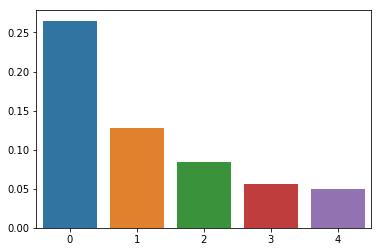

In [29]:
sns.barplot(x=np.arange(pca.n_components), y=pca.explained_variance_ratio_)

This is what it says in the paper

We denote the projection of a vector $ v $ onto $ B $ by

$$ v_B = \sum_{j=1}^{k} (v \cdot b_j) b_j $$

For each word $ w \in N $, let $ \vec{w} $ be re-embedded to
$$ \vec{w} := \vec{w} - \vec{w_{B}} / || \vec{w} - \vec{w_{B}} || $$

$$ \mu := \sum_{w \in E}w / |E| $$
$$ \nu := \mu - \mu_B $$
For each $ w \in E $, 
$$ \vec{w} := \nu + \sqrt{1 - ||\nu||^2}\frac{\vec{w_B} - \mu_B}{||\vec{w_B} - \mu_B||} $$

In [30]:
def remove_subspace(X: np.ndarray, subspace: np.ndarray, norm=True) -> np.ndarray:
    Xb = ((X @ subspace.T) @ subspace) # projection onto biased subspace
    X = (X - Xb) / (np.linalg.norm(X - Xb))
    if norm:
        mu = X.mean(0)
        mub = Xb.mean(0)
        nu = mu - mub
        return nu + np.sqrt(1 - nu**2) * (Xb - mub) / np.linalg.norm(Xb - mub)
    else:
        return X

In [31]:
remove_subspace(male_vecs, pca.components_)

array([[ 0.05750234, -0.04525623, -0.02131852, ...,  0.0319312 ,
        -0.15257937,  0.00385126],
       [ 0.05876423, -0.04803424, -0.02217929, ...,  0.03185872,
        -0.15659258,  0.00598402],
       [ 0.0568763 , -0.04828515, -0.0227893 , ...,  0.03089112,
        -0.15277423,  0.00733754],
       ...,
       [ 0.0594499 , -0.04949377, -0.02185628, ...,  0.03214797,
        -0.15959617,  0.00524225],
       [ 0.05834688, -0.04916738, -0.02396237, ...,  0.03053905,
        -0.15623659,  0.00721749],
       [ 0.05987932, -0.04884812, -0.02171919, ...,  0.03200333,
        -0.1593855 ,  0.00586626]], dtype=float32)

### Newly checking for differences

In [32]:
def pp(X: np.ndarray) -> np.ndarray:
    """Postprocess"""
    return remove_subspace(np.expand_dims(X, 0), pca.components_, norm=False)[0]

In [33]:
def compute_new_diff_similarity(cwords1, cwords2):
    cword11, cword12 = cwords1
    cword21, cword22 = cwords2
    return cosine_similarity(pp(get_word_vector(cword11)) - pp(get_word_vector(cword12)),
                             pp(get_word_vector(cword21)) - pp(get_word_vector(cword22)))

Similarities are being reduced, so there is a shared gender subspace to a certain extent.

In [34]:
(compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The nurse went to the office.", "nurse"))
),
compute_new_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The nurse went to the office.", "nurse"))
))

(0.13653895, 0.034595642)

In [35]:
(compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
),
compute_new_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
))

(0.20923696, 0.12811854)

In [36]:
(compute_diff_similarity(
    (ContextWord("he likes sports.", "he"), ContextWord("she likes sports.", "she")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
),
compute_new_diff_similarity(
    (ContextWord("he likes sports.", "he"), ContextWord("she likes sports.", "she")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
))

(0.21795174, 0.12754752)

# Checking for change in bias score

Let's see if the bias score decreases with this transformation

In [37]:
def compute_postprocess_bias_score(row):
    sentence, mword, fword, prior_bias = (row["sentence"], row["mword"], 
                                          row["fword"], row["prior_bias"])
    mwi, fwi = processor.token_to_index(mword), processor.token_to_index(fword)
    wv = get_word_vector(
        ContextWord(sentence, "[MASK]"),
        use_last_mask=True,
    )
    wv = pp(wv)
    logits = to_logits(wv)
    subject_fill_bias = logits[fwi] - logits[mwi]
    return subject_fill_bias - prior_bias

Bias is reduced here

In [38]:
tqdm.pandas()
df_train["bias_score_after"] = df_train.progress_apply(compute_postprocess_bias_score, axis=1)

  0%|          | 0/864 [00:00<?, ?it/s]

  0%|          | 2/864 [00:00<02:03,  6.96it/s]

  0%|          | 3/864 [00:00<02:03,  6.95it/s]

  0%|          | 4/864 [00:00<02:04,  6.90it/s]

  1%|          | 5/864 [00:00<02:04,  6.88it/s]

  1%|          | 6/864 [00:00<01:59,  7.15it/s]

  1%|          | 7/864 [00:00<01:57,  7.30it/s]

  1%|          | 8/864 [00:01<02:02,  7.01it/s]

  1%|          | 9/864 [00:01<02:05,  6.80it/s]

  1%|          | 10/864 [00:01<02:03,  6.89it/s]

  1%|▏         | 11/864 [00:01<02:00,  7.10it/s]

  1%|▏         | 12/864 [00:01<01:56,  7.34it/s]

  2%|▏         | 13/864 [00:01<01:59,  7.12it/s]

  2%|▏         | 14/864 [00:02<02:07,  6.68it/s]

  2%|▏         | 15/864 [00:02<02:03,  6.88it/s]

  2%|▏         | 16/864 [00:02<02:03,  6.89it/s]

  2%|▏         | 17/864 [00:02<02:03,  6.85it/s]

  2%|▏         | 18/864 [00:02<02:05,  6.76it/s]

  2%|▏         | 19/864 [00:02<02:02,  6.89it/s]

  2%|▏         | 20/864 [00:02<02:03,  6.83it/s]

  2%|▏         | 21/864 [00:03<02:07,  6.61it/s]

  3%|▎         | 22/864 [00:03<02:14,  6.28it/s]

  3%|▎         | 23/864 [00:03<02:11,  6.40it/s]

  3%|▎         | 24/864 [00:03<02:06,  6.62it/s]

  3%|▎         | 25/864 [00:03<02:07,  6.56it/s]

  3%|▎         | 26/864 [00:03<02:08,  6.54it/s]

  3%|▎         | 27/864 [00:03<02:01,  6.87it/s]

  3%|▎         | 28/864 [00:04<02:05,  6.65it/s]

  3%|▎         | 29/864 [00:04<02:04,  6.72it/s]

  3%|▎         | 30/864 [00:04<02:00,  6.95it/s]

  4%|▎         | 31/864 [00:04<01:58,  7.05it/s]

  4%|▎         | 32/864 [00:04<02:02,  6.80it/s]

  4%|▍         | 33/864 [00:04<02:00,  6.89it/s]

  4%|▍         | 34/864 [00:04<01:57,  7.05it/s]

  4%|▍         | 35/864 [00:05<02:05,  6.63it/s]

  4%|▍         | 36/864 [00:05<02:08,  6.43it/s]

  4%|▍         | 37/864 [00:05<02:09,  6.41it/s]

  4%|▍         | 38/864 [00:05<02:10,  6.31it/s]

  5%|▍         | 39/864 [00:05<02:10,  6.32it/s]

  5%|▍         | 40/864 [00:06<02:39,  5.16it/s]

  5%|▍         | 41/864 [00:06<02:34,  5.33it/s]

  5%|▍         | 42/864 [00:06<02:27,  5.59it/s]

  5%|▍         | 43/864 [00:06<02:20,  5.85it/s]

  5%|▌         | 44/864 [00:06<02:19,  5.87it/s]

  5%|▌         | 45/864 [00:06<02:16,  6.02it/s]

  5%|▌         | 46/864 [00:07<02:18,  5.91it/s]

  5%|▌         | 47/864 [00:07<02:22,  5.74it/s]

  6%|▌         | 48/864 [00:07<02:16,  5.97it/s]

  6%|▌         | 49/864 [00:07<02:16,  5.99it/s]

  6%|▌         | 50/864 [00:07<02:12,  6.14it/s]

  6%|▌         | 51/864 [00:07<02:24,  5.61it/s]

  6%|▌         | 52/864 [00:08<02:33,  5.29it/s]

  6%|▌         | 53/864 [00:08<02:19,  5.83it/s]

  6%|▋         | 54/864 [00:08<02:11,  6.18it/s]

  6%|▋         | 55/864 [00:08<02:02,  6.60it/s]

  6%|▋         | 56/864 [00:08<02:15,  5.96it/s]

  7%|▋         | 57/864 [00:08<02:20,  5.75it/s]

  7%|▋         | 58/864 [00:09<02:24,  5.60it/s]

  7%|▋         | 59/864 [00:09<02:24,  5.58it/s]

  7%|▋         | 60/864 [00:09<02:18,  5.81it/s]

  7%|▋         | 61/864 [00:09<02:16,  5.87it/s]

  7%|▋         | 62/864 [00:09<02:18,  5.79it/s]

  7%|▋         | 63/864 [00:09<02:25,  5.50it/s]

  7%|▋         | 64/864 [00:10<02:18,  5.78it/s]

  8%|▊         | 65/864 [00:10<02:13,  6.00it/s]

  8%|▊         | 66/864 [00:10<02:13,  6.00it/s]

  8%|▊         | 67/864 [00:10<02:10,  6.10it/s]

  8%|▊         | 68/864 [00:10<02:11,  6.04it/s]

  8%|▊         | 69/864 [00:10<02:10,  6.11it/s]

  8%|▊         | 70/864 [00:11<02:10,  6.08it/s]

  8%|▊         | 71/864 [00:11<02:19,  5.70it/s]

  8%|▊         | 72/864 [00:11<02:16,  5.81it/s]

  8%|▊         | 73/864 [00:11<02:19,  5.68it/s]

  9%|▊         | 74/864 [00:11<02:28,  5.30it/s]

  9%|▊         | 75/864 [00:12<02:29,  5.28it/s]

  9%|▉         | 76/864 [00:12<02:26,  5.38it/s]

  9%|▉         | 77/864 [00:12<02:22,  5.52it/s]

  9%|▉         | 78/864 [00:12<02:18,  5.68it/s]

  9%|▉         | 79/864 [00:12<02:16,  5.76it/s]

  9%|▉         | 80/864 [00:12<02:11,  5.96it/s]

  9%|▉         | 81/864 [00:13<02:11,  5.95it/s]

  9%|▉         | 82/864 [00:13<02:18,  5.65it/s]

 10%|▉         | 83/864 [00:13<02:19,  5.58it/s]

 10%|▉         | 84/864 [00:13<02:17,  5.65it/s]

 10%|▉         | 85/864 [00:13<02:16,  5.72it/s]

 10%|▉         | 86/864 [00:13<02:11,  5.92it/s]

 10%|█         | 87/864 [00:14<02:06,  6.16it/s]

 10%|█         | 88/864 [00:14<02:03,  6.30it/s]

 10%|█         | 89/864 [00:14<01:59,  6.51it/s]

 10%|█         | 90/864 [00:14<01:57,  6.59it/s]

 11%|█         | 91/864 [00:14<01:53,  6.82it/s]

 11%|█         | 92/864 [00:14<01:53,  6.78it/s]

 11%|█         | 93/864 [00:14<01:48,  7.09it/s]

 11%|█         | 94/864 [00:15<01:45,  7.31it/s]

 11%|█         | 95/864 [00:15<02:00,  6.38it/s]

 11%|█         | 96/864 [00:15<02:00,  6.36it/s]

 11%|█         | 97/864 [00:15<01:55,  6.62it/s]

 11%|█▏        | 98/864 [00:15<01:47,  7.10it/s]

 11%|█▏        | 99/864 [00:15<01:44,  7.35it/s]

 12%|█▏        | 100/864 [00:15<01:43,  7.40it/s]

 12%|█▏        | 101/864 [00:16<01:43,  7.38it/s]

 12%|█▏        | 102/864 [00:16<01:41,  7.54it/s]

 12%|█▏        | 103/864 [00:16<01:39,  7.65it/s]

 12%|█▏        | 104/864 [00:16<01:37,  7.83it/s]

 12%|█▏        | 105/864 [00:16<01:36,  7.90it/s]

 12%|█▏        | 106/864 [00:16<01:35,  7.98it/s]

 12%|█▏        | 107/864 [00:16<01:37,  7.76it/s]

 12%|█▎        | 108/864 [00:16<01:38,  7.70it/s]

 13%|█▎        | 109/864 [00:17<01:34,  7.96it/s]

 13%|█▎        | 110/864 [00:17<01:45,  7.18it/s]

 13%|█▎        | 111/864 [00:17<01:46,  7.08it/s]

 13%|█▎        | 112/864 [00:17<01:48,  6.94it/s]

 13%|█▎        | 113/864 [00:17<01:44,  7.16it/s]

 13%|█▎        | 114/864 [00:17<01:47,  6.96it/s]

 13%|█▎        | 115/864 [00:18<01:58,  6.31it/s]

 13%|█▎        | 116/864 [00:18<01:52,  6.63it/s]

 14%|█▎        | 117/864 [00:18<01:48,  6.91it/s]

 14%|█▎        | 118/864 [00:18<01:46,  7.02it/s]

 14%|█▍        | 119/864 [00:18<01:42,  7.26it/s]

 14%|█▍        | 120/864 [00:18<01:41,  7.34it/s]

 14%|█▍        | 121/864 [00:18<01:40,  7.37it/s]

 14%|█▍        | 122/864 [00:18<01:45,  7.05it/s]

 14%|█▍        | 123/864 [00:19<01:42,  7.25it/s]

 14%|█▍        | 124/864 [00:19<01:41,  7.28it/s]

 14%|█▍        | 125/864 [00:19<01:40,  7.36it/s]

 15%|█▍        | 126/864 [00:19<01:40,  7.37it/s]

 15%|█▍        | 127/864 [00:19<02:04,  5.93it/s]

 15%|█▍        | 128/864 [00:19<01:56,  6.31it/s]

 15%|█▍        | 129/864 [00:20<01:50,  6.68it/s]

 15%|█▌        | 130/864 [00:20<01:45,  6.93it/s]

 15%|█▌        | 131/864 [00:20<01:44,  7.01it/s]

 15%|█▌        | 132/864 [00:20<01:45,  6.92it/s]

 15%|█▌        | 133/864 [00:20<01:46,  6.86it/s]

 16%|█▌        | 134/864 [00:20<01:43,  7.05it/s]

 16%|█▌        | 135/864 [00:20<01:41,  7.19it/s]

 16%|█▌        | 136/864 [00:20<01:39,  7.28it/s]

 16%|█▌        | 137/864 [00:21<01:40,  7.22it/s]

 16%|█▌        | 138/864 [00:21<01:38,  7.39it/s]

 16%|█▌        | 139/864 [00:21<01:33,  7.73it/s]

 16%|█▌        | 140/864 [00:21<01:46,  6.83it/s]

 16%|█▋        | 141/864 [00:21<02:00,  6.02it/s]

 16%|█▋        | 142/864 [00:21<01:54,  6.32it/s]

 17%|█▋        | 143/864 [00:22<01:45,  6.86it/s]

 17%|█▋        | 144/864 [00:22<01:39,  7.25it/s]

 17%|█▋        | 145/864 [00:22<01:34,  7.58it/s]

 17%|█▋        | 146/864 [00:22<01:44,  6.86it/s]

 17%|█▋        | 147/864 [00:22<01:47,  6.66it/s]

 17%|█▋        | 148/864 [00:22<01:49,  6.57it/s]

 17%|█▋        | 149/864 [00:22<01:43,  6.92it/s]

 17%|█▋        | 150/864 [00:23<01:45,  6.78it/s]

 17%|█▋        | 151/864 [00:23<01:42,  6.98it/s]

 18%|█▊        | 152/864 [00:23<01:38,  7.20it/s]

 18%|█▊        | 153/864 [00:23<01:37,  7.29it/s]

 18%|█▊        | 154/864 [00:23<01:52,  6.30it/s]

 18%|█▊        | 155/864 [00:23<01:47,  6.57it/s]

 18%|█▊        | 156/864 [00:23<01:46,  6.66it/s]

 18%|█▊        | 157/864 [00:24<01:45,  6.73it/s]

 18%|█▊        | 158/864 [00:24<01:42,  6.89it/s]

 18%|█▊        | 159/864 [00:24<01:39,  7.06it/s]

 19%|█▊        | 160/864 [00:24<01:42,  6.87it/s]

 19%|█▊        | 161/864 [00:24<01:43,  6.77it/s]

 19%|█▉        | 162/864 [00:24<01:40,  6.99it/s]

 19%|█▉        | 163/864 [00:24<01:41,  6.93it/s]

 19%|█▉        | 164/864 [00:25<01:40,  6.95it/s]

 19%|█▉        | 165/864 [00:25<01:38,  7.09it/s]

 19%|█▉        | 166/864 [00:25<01:43,  6.74it/s]

 19%|█▉        | 167/864 [00:25<01:34,  7.39it/s]

 19%|█▉        | 168/864 [00:25<01:45,  6.61it/s]

 20%|█▉        | 169/864 [00:25<01:45,  6.59it/s]

 20%|█▉        | 170/864 [00:25<01:43,  6.71it/s]

 20%|█▉        | 171/864 [00:26<01:40,  6.93it/s]

 20%|█▉        | 172/864 [00:26<01:39,  6.96it/s]

 20%|██        | 173/864 [00:26<01:36,  7.16it/s]

 20%|██        | 174/864 [00:26<01:37,  7.07it/s]

 20%|██        | 175/864 [00:26<01:37,  7.08it/s]

 20%|██        | 176/864 [00:26<01:37,  7.04it/s]

 20%|██        | 177/864 [00:26<01:38,  6.94it/s]

 21%|██        | 178/864 [00:27<01:38,  6.96it/s]

 21%|██        | 179/864 [00:27<01:39,  6.85it/s]

 21%|██        | 180/864 [00:27<01:45,  6.49it/s]

 21%|██        | 181/864 [00:27<01:35,  7.14it/s]

 21%|██        | 182/864 [00:27<01:36,  7.05it/s]

 21%|██        | 183/864 [00:27<01:34,  7.24it/s]

 21%|██▏       | 184/864 [00:27<01:33,  7.27it/s]

 21%|██▏       | 185/864 [00:28<01:33,  7.28it/s]

 22%|██▏       | 186/864 [00:28<01:29,  7.56it/s]

 22%|██▏       | 187/864 [00:28<01:29,  7.58it/s]

 22%|██▏       | 188/864 [00:28<01:27,  7.74it/s]

 22%|██▏       | 189/864 [00:28<01:26,  7.83it/s]

 22%|██▏       | 190/864 [00:28<01:25,  7.86it/s]

 22%|██▏       | 191/864 [00:28<01:23,  8.11it/s]

 22%|██▏       | 192/864 [00:28<01:24,  8.00it/s]

 22%|██▏       | 193/864 [00:29<01:24,  7.95it/s]

 22%|██▏       | 194/864 [00:29<01:20,  8.27it/s]

 23%|██▎       | 195/864 [00:29<01:24,  7.91it/s]

 23%|██▎       | 196/864 [00:29<01:36,  6.95it/s]

 23%|██▎       | 197/864 [00:29<01:34,  7.09it/s]

 23%|██▎       | 198/864 [00:29<01:30,  7.36it/s]

 23%|██▎       | 199/864 [00:29<01:27,  7.61it/s]

 23%|██▎       | 200/864 [00:30<01:25,  7.74it/s]

 23%|██▎       | 201/864 [00:30<01:25,  7.80it/s]

 23%|██▎       | 202/864 [00:30<01:24,  7.88it/s]

 23%|██▎       | 203/864 [00:30<01:24,  7.85it/s]

 24%|██▎       | 204/864 [00:30<01:23,  7.87it/s]

 24%|██▎       | 205/864 [00:30<01:23,  7.89it/s]

 24%|██▍       | 206/864 [00:30<01:22,  7.95it/s]

 24%|██▍       | 207/864 [00:30<01:22,  7.98it/s]

 24%|██▍       | 208/864 [00:31<01:22,  7.97it/s]

 24%|██▍       | 209/864 [00:31<01:20,  8.15it/s]

 24%|██▍       | 210/864 [00:31<01:21,  8.05it/s]

 24%|██▍       | 211/864 [00:31<01:29,  7.27it/s]

 25%|██▍       | 212/864 [00:31<01:28,  7.40it/s]

 25%|██▍       | 213/864 [00:31<01:28,  7.39it/s]

 25%|██▍       | 214/864 [00:31<01:28,  7.33it/s]

 25%|██▍       | 215/864 [00:31<01:29,  7.25it/s]

 25%|██▌       | 216/864 [00:32<01:29,  7.28it/s]

 25%|██▌       | 217/864 [00:32<01:38,  6.59it/s]

 25%|██▌       | 218/864 [00:32<01:40,  6.44it/s]

 25%|██▌       | 219/864 [00:32<01:37,  6.61it/s]

 25%|██▌       | 220/864 [00:32<01:36,  6.71it/s]

 26%|██▌       | 221/864 [00:32<01:36,  6.68it/s]

 26%|██▌       | 222/864 [00:33<01:36,  6.66it/s]

 26%|██▌       | 223/864 [00:33<01:34,  6.79it/s]

 26%|██▌       | 224/864 [00:33<01:54,  5.59it/s]

 26%|██▌       | 225/864 [00:33<01:48,  5.91it/s]

 26%|██▌       | 226/864 [00:33<01:44,  6.08it/s]

 26%|██▋       | 227/864 [00:33<01:42,  6.20it/s]

 26%|██▋       | 228/864 [00:34<01:40,  6.32it/s]

 27%|██▋       | 229/864 [00:34<01:37,  6.52it/s]

 27%|██▋       | 230/864 [00:34<01:34,  6.69it/s]

 27%|██▋       | 231/864 [00:34<01:32,  6.81it/s]

 27%|██▋       | 232/864 [00:34<01:34,  6.72it/s]

 27%|██▋       | 233/864 [00:34<01:36,  6.55it/s]

 27%|██▋       | 234/864 [00:34<01:38,  6.37it/s]

 27%|██▋       | 235/864 [00:35<01:45,  5.96it/s]

 27%|██▋       | 236/864 [00:35<01:49,  5.73it/s]

 27%|██▋       | 237/864 [00:35<01:46,  5.88it/s]

 28%|██▊       | 238/864 [00:35<01:36,  6.47it/s]

 28%|██▊       | 239/864 [00:35<01:39,  6.27it/s]

 28%|██▊       | 240/864 [00:35<01:50,  5.67it/s]

 28%|██▊       | 241/864 [00:36<01:49,  5.69it/s]

 28%|██▊       | 242/864 [00:36<01:47,  5.78it/s]

 28%|██▊       | 243/864 [00:36<01:47,  5.79it/s]

 28%|██▊       | 244/864 [00:36<01:44,  5.93it/s]

 28%|██▊       | 245/864 [00:36<01:46,  5.79it/s]

 28%|██▊       | 246/864 [00:37<01:56,  5.32it/s]

 29%|██▊       | 247/864 [00:37<01:59,  5.18it/s]

 29%|██▊       | 248/864 [00:37<02:11,  4.67it/s]

 29%|██▉       | 249/864 [00:37<02:00,  5.12it/s]

 29%|██▉       | 250/864 [00:37<01:51,  5.50it/s]

 29%|██▉       | 251/864 [00:38<01:46,  5.75it/s]

 29%|██▉       | 252/864 [00:38<01:38,  6.22it/s]

 29%|██▉       | 253/864 [00:38<01:33,  6.54it/s]

 29%|██▉       | 254/864 [00:38<01:33,  6.50it/s]

 30%|██▉       | 255/864 [00:38<01:29,  6.78it/s]

 30%|██▉       | 256/864 [00:38<01:29,  6.78it/s]

 30%|██▉       | 257/864 [00:38<01:30,  6.72it/s]

 30%|██▉       | 258/864 [00:39<01:29,  6.74it/s]

 30%|██▉       | 259/864 [00:39<01:26,  7.00it/s]

 30%|███       | 260/864 [00:39<01:44,  5.79it/s]

 30%|███       | 261/864 [00:39<01:42,  5.89it/s]

 30%|███       | 262/864 [00:39<01:37,  6.17it/s]

 30%|███       | 263/864 [00:39<01:32,  6.47it/s]

 31%|███       | 264/864 [00:39<01:33,  6.45it/s]

 31%|███       | 265/864 [00:40<01:31,  6.55it/s]

 31%|███       | 266/864 [00:40<01:28,  6.73it/s]

 31%|███       | 267/864 [00:40<01:29,  6.66it/s]

 31%|███       | 268/864 [00:40<01:29,  6.68it/s]

 31%|███       | 269/864 [00:40<01:27,  6.82it/s]

 31%|███▏      | 270/864 [00:40<01:28,  6.74it/s]

 31%|███▏      | 271/864 [00:41<01:27,  6.76it/s]

 31%|███▏      | 272/864 [00:41<01:33,  6.35it/s]

 32%|███▏      | 273/864 [00:41<01:28,  6.67it/s]

 32%|███▏      | 274/864 [00:41<01:26,  6.85it/s]

 32%|███▏      | 275/864 [00:41<01:25,  6.87it/s]

 32%|███▏      | 276/864 [00:41<01:22,  7.16it/s]

 32%|███▏      | 277/864 [00:41<01:17,  7.59it/s]

 32%|███▏      | 278/864 [00:41<01:16,  7.63it/s]

 32%|███▏      | 279/864 [00:42<01:14,  7.83it/s]

 32%|███▏      | 280/864 [00:42<01:12,  8.00it/s]

 33%|███▎      | 281/864 [00:42<01:13,  7.88it/s]

 33%|███▎      | 282/864 [00:42<01:14,  7.84it/s]

 33%|███▎      | 283/864 [00:42<01:13,  7.91it/s]

 33%|███▎      | 284/864 [00:42<01:12,  7.98it/s]

 33%|███▎      | 285/864 [00:42<01:11,  8.15it/s]

 33%|███▎      | 286/864 [00:42<01:10,  8.25it/s]

 33%|███▎      | 287/864 [00:43<01:09,  8.34it/s]

 33%|███▎      | 288/864 [00:43<01:08,  8.36it/s]

 33%|███▎      | 289/864 [00:43<01:10,  8.17it/s]

 34%|███▎      | 290/864 [00:43<01:14,  7.71it/s]

 34%|███▎      | 291/864 [00:43<01:13,  7.79it/s]

 34%|███▍      | 292/864 [00:43<01:11,  7.97it/s]

 34%|███▍      | 293/864 [00:43<01:10,  8.11it/s]

 34%|███▍      | 294/864 [00:43<01:10,  8.12it/s]

 34%|███▍      | 295/864 [00:44<01:11,  7.92it/s]

 34%|███▍      | 296/864 [00:44<01:12,  7.84it/s]

 34%|███▍      | 297/864 [00:44<01:12,  7.79it/s]

 34%|███▍      | 298/864 [00:44<01:12,  7.85it/s]

 35%|███▍      | 299/864 [00:44<01:13,  7.74it/s]

 35%|███▍      | 300/864 [00:44<01:12,  7.80it/s]

 35%|███▍      | 301/864 [00:44<01:12,  7.75it/s]

 35%|███▍      | 302/864 [00:44<01:13,  7.64it/s]

 35%|███▌      | 303/864 [00:45<01:12,  7.74it/s]

 35%|███▌      | 304/864 [00:45<01:14,  7.50it/s]

 35%|███▌      | 305/864 [00:45<01:17,  7.23it/s]

 35%|███▌      | 306/864 [00:45<01:17,  7.18it/s]

 36%|███▌      | 307/864 [00:45<01:15,  7.38it/s]

 36%|███▌      | 308/864 [00:45<01:16,  7.28it/s]

 36%|███▌      | 309/864 [00:45<01:17,  7.16it/s]

 36%|███▌      | 310/864 [00:46<01:16,  7.22it/s]

 36%|███▌      | 311/864 [00:46<01:20,  6.91it/s]

 36%|███▌      | 312/864 [00:46<01:25,  6.43it/s]

 36%|███▌      | 313/864 [00:46<01:25,  6.46it/s]

 36%|███▋      | 314/864 [00:46<01:25,  6.46it/s]

 36%|███▋      | 315/864 [00:46<01:29,  6.11it/s]

 37%|███▋      | 316/864 [00:47<01:45,  5.20it/s]

 37%|███▋      | 317/864 [00:47<02:01,  4.49it/s]

 37%|███▋      | 318/864 [00:47<01:53,  4.81it/s]

 37%|███▋      | 319/864 [00:47<01:42,  5.29it/s]

 37%|███▋      | 320/864 [00:47<01:36,  5.63it/s]

 37%|███▋      | 321/864 [00:48<01:30,  5.99it/s]

 37%|███▋      | 322/864 [00:48<01:26,  6.26it/s]

 37%|███▋      | 323/864 [00:48<01:26,  6.27it/s]

 38%|███▊      | 324/864 [00:48<01:22,  6.57it/s]

 38%|███▊      | 325/864 [00:48<01:21,  6.63it/s]

 38%|███▊      | 326/864 [00:48<01:21,  6.62it/s]

 38%|███▊      | 327/864 [00:49<01:57,  4.58it/s]

 38%|███▊      | 328/864 [00:49<01:56,  4.60it/s]

 38%|███▊      | 329/864 [00:49<01:46,  5.03it/s]

 38%|███▊      | 330/864 [00:49<01:37,  5.50it/s]

 38%|███▊      | 331/864 [00:49<01:39,  5.33it/s]

 38%|███▊      | 332/864 [00:50<01:47,  4.95it/s]

 39%|███▊      | 333/864 [00:50<01:48,  4.89it/s]

 39%|███▊      | 334/864 [00:50<01:50,  4.81it/s]

 39%|███▉      | 335/864 [00:50<01:54,  4.62it/s]

 39%|███▉      | 336/864 [00:51<01:50,  4.79it/s]

 39%|███▉      | 337/864 [00:51<01:48,  4.86it/s]

 39%|███▉      | 338/864 [00:51<02:09,  4.07it/s]

 39%|███▉      | 339/864 [00:51<01:55,  4.53it/s]

 39%|███▉      | 340/864 [00:51<01:49,  4.79it/s]

 39%|███▉      | 341/864 [00:52<01:44,  5.02it/s]

 40%|███▉      | 342/864 [00:52<01:40,  5.18it/s]

 40%|███▉      | 343/864 [00:52<01:48,  4.82it/s]

 40%|███▉      | 344/864 [00:52<01:46,  4.87it/s]

 40%|███▉      | 345/864 [00:52<01:39,  5.20it/s]

 40%|████      | 346/864 [00:53<01:48,  4.77it/s]

 40%|████      | 347/864 [00:53<01:43,  5.00it/s]

 40%|████      | 348/864 [00:53<01:56,  4.44it/s]

 40%|████      | 349/864 [00:53<01:56,  4.42it/s]

 41%|████      | 350/864 [00:53<01:53,  4.54it/s]

 41%|████      | 351/864 [00:54<01:48,  4.73it/s]

 41%|████      | 352/864 [00:54<01:47,  4.74it/s]

 41%|████      | 353/864 [00:54<01:49,  4.67it/s]

 41%|████      | 354/864 [00:54<01:41,  5.05it/s]

 41%|████      | 355/864 [00:54<01:30,  5.63it/s]

 41%|████      | 356/864 [00:55<01:30,  5.60it/s]

 41%|████▏     | 357/864 [00:55<01:29,  5.66it/s]

 41%|████▏     | 358/864 [00:55<01:27,  5.78it/s]

 42%|████▏     | 359/864 [00:55<01:30,  5.59it/s]

 42%|████▏     | 360/864 [00:55<01:30,  5.55it/s]

 42%|████▏     | 361/864 [00:55<01:24,  5.94it/s]

 42%|████▏     | 362/864 [00:56<01:21,  6.16it/s]

 42%|████▏     | 363/864 [00:56<01:15,  6.64it/s]

 42%|████▏     | 364/864 [00:56<01:15,  6.60it/s]

 42%|████▏     | 365/864 [00:56<01:11,  6.97it/s]

 42%|████▏     | 366/864 [00:56<01:11,  6.93it/s]

 42%|████▏     | 367/864 [00:56<01:10,  7.01it/s]

 43%|████▎     | 368/864 [00:56<01:10,  7.04it/s]

 43%|████▎     | 369/864 [00:57<01:09,  7.15it/s]

 43%|████▎     | 370/864 [00:57<01:07,  7.35it/s]

 43%|████▎     | 371/864 [00:57<01:06,  7.44it/s]

 43%|████▎     | 372/864 [00:57<01:08,  7.14it/s]

 43%|████▎     | 373/864 [00:57<01:08,  7.20it/s]

 43%|████▎     | 374/864 [00:57<01:07,  7.29it/s]

 43%|████▎     | 375/864 [00:57<01:07,  7.28it/s]

 44%|████▎     | 376/864 [00:57<01:03,  7.66it/s]

 44%|████▎     | 377/864 [00:58<01:03,  7.71it/s]

 44%|████▍     | 378/864 [00:58<01:01,  7.90it/s]

 44%|████▍     | 379/864 [00:58<01:00,  7.98it/s]

 44%|████▍     | 380/864 [00:58<01:00,  8.05it/s]

 44%|████▍     | 381/864 [00:58<01:02,  7.69it/s]

 44%|████▍     | 382/864 [00:58<01:03,  7.61it/s]

 44%|████▍     | 383/864 [00:58<01:01,  7.78it/s]

 44%|████▍     | 384/864 [00:58<01:01,  7.83it/s]

 45%|████▍     | 385/864 [00:59<01:02,  7.67it/s]

 45%|████▍     | 386/864 [00:59<01:01,  7.81it/s]

 45%|████▍     | 387/864 [00:59<01:02,  7.58it/s]

 45%|████▍     | 388/864 [00:59<01:02,  7.68it/s]

 45%|████▌     | 389/864 [00:59<01:01,  7.69it/s]

 45%|████▌     | 390/864 [00:59<01:02,  7.61it/s]

 45%|████▌     | 391/864 [00:59<01:00,  7.85it/s]

 45%|████▌     | 392/864 [01:00<01:01,  7.68it/s]

 45%|████▌     | 393/864 [01:00<01:02,  7.59it/s]

 46%|████▌     | 394/864 [01:00<01:00,  7.83it/s]

 46%|████▌     | 395/864 [01:00<01:01,  7.58it/s]

 46%|████▌     | 396/864 [01:00<01:03,  7.41it/s]

 46%|████▌     | 397/864 [01:00<01:12,  6.43it/s]

 46%|████▌     | 398/864 [01:00<01:14,  6.22it/s]

 46%|████▌     | 399/864 [01:01<01:13,  6.31it/s]

 46%|████▋     | 400/864 [01:01<01:13,  6.35it/s]

 46%|████▋     | 401/864 [01:01<01:15,  6.10it/s]

 47%|████▋     | 402/864 [01:01<01:18,  5.86it/s]

 47%|████▋     | 403/864 [01:01<01:12,  6.32it/s]

 47%|████▋     | 404/864 [01:01<01:09,  6.65it/s]

 47%|████▋     | 405/864 [01:02<01:07,  6.79it/s]

 47%|████▋     | 406/864 [01:02<01:05,  6.97it/s]

 47%|████▋     | 407/864 [01:02<01:04,  7.14it/s]

 47%|████▋     | 408/864 [01:02<01:04,  7.05it/s]

 47%|████▋     | 409/864 [01:02<01:04,  7.07it/s]

 47%|████▋     | 410/864 [01:02<01:16,  5.91it/s]

 48%|████▊     | 411/864 [01:02<01:13,  6.18it/s]

 48%|████▊     | 412/864 [01:03<01:10,  6.42it/s]

 48%|████▊     | 413/864 [01:03<01:10,  6.39it/s]

 48%|████▊     | 414/864 [01:03<01:11,  6.28it/s]

 48%|████▊     | 415/864 [01:03<01:10,  6.35it/s]

 48%|████▊     | 416/864 [01:03<01:05,  6.86it/s]

 48%|████▊     | 417/864 [01:03<01:01,  7.30it/s]

 48%|████▊     | 418/864 [01:03<01:00,  7.41it/s]

 48%|████▊     | 419/864 [01:04<01:07,  6.63it/s]

 49%|████▊     | 420/864 [01:04<01:10,  6.33it/s]

 49%|████▊     | 421/864 [01:04<01:10,  6.29it/s]

 49%|████▉     | 422/864 [01:04<01:16,  5.77it/s]

 49%|████▉     | 423/864 [01:04<01:20,  5.48it/s]

 49%|████▉     | 424/864 [01:05<01:15,  5.83it/s]

 49%|████▉     | 425/864 [01:05<01:09,  6.29it/s]

 49%|████▉     | 426/864 [01:05<01:06,  6.58it/s]

 49%|████▉     | 427/864 [01:05<01:11,  6.15it/s]

 50%|████▉     | 428/864 [01:05<01:09,  6.24it/s]

 50%|████▉     | 429/864 [01:05<01:06,  6.49it/s]

 50%|████▉     | 430/864 [01:05<01:05,  6.65it/s]

 50%|████▉     | 431/864 [01:06<01:03,  6.81it/s]

 50%|█████     | 432/864 [01:06<01:03,  6.85it/s]

 50%|█████     | 433/864 [01:06<01:02,  6.94it/s]

 50%|█████     | 434/864 [01:06<01:00,  7.07it/s]

 50%|█████     | 435/864 [01:06<01:16,  5.62it/s]

 50%|█████     | 436/864 [01:06<01:12,  5.92it/s]

 51%|█████     | 437/864 [01:07<01:08,  6.27it/s]

 51%|█████     | 438/864 [01:07<01:04,  6.65it/s]

 51%|█████     | 439/864 [01:07<01:03,  6.68it/s]

 51%|█████     | 440/864 [01:07<01:05,  6.49it/s]

 51%|█████     | 441/864 [01:07<01:08,  6.14it/s]

 51%|█████     | 442/864 [01:07<01:04,  6.56it/s]

 51%|█████▏    | 443/864 [01:07<01:00,  6.91it/s]

 51%|█████▏    | 444/864 [01:08<01:00,  6.93it/s]

 52%|█████▏    | 445/864 [01:08<01:00,  6.96it/s]

 52%|█████▏    | 446/864 [01:08<00:59,  6.98it/s]

 52%|█████▏    | 447/864 [01:08<00:59,  7.05it/s]

 52%|█████▏    | 448/864 [01:08<01:06,  6.27it/s]

 52%|█████▏    | 449/864 [01:08<01:04,  6.48it/s]

 52%|█████▏    | 450/864 [01:08<01:04,  6.39it/s]

 52%|█████▏    | 451/864 [01:09<01:02,  6.58it/s]

 52%|█████▏    | 452/864 [01:09<01:01,  6.66it/s]

 52%|█████▏    | 453/864 [01:09<00:59,  6.96it/s]

 53%|█████▎    | 454/864 [01:09<00:58,  6.97it/s]

 53%|█████▎    | 455/864 [01:09<00:56,  7.26it/s]

 53%|█████▎    | 456/864 [01:09<00:54,  7.49it/s]

 53%|█████▎    | 457/864 [01:09<00:52,  7.75it/s]

 53%|█████▎    | 458/864 [01:10<00:52,  7.73it/s]

 53%|█████▎    | 459/864 [01:10<00:49,  8.13it/s]

 53%|█████▎    | 460/864 [01:10<00:48,  8.28it/s]

 53%|█████▎    | 461/864 [01:10<00:48,  8.28it/s]

 53%|█████▎    | 462/864 [01:10<00:50,  7.97it/s]

 54%|█████▎    | 463/864 [01:10<00:48,  8.22it/s]

 54%|█████▎    | 464/864 [01:10<00:48,  8.18it/s]

 54%|█████▍    | 465/864 [01:10<00:47,  8.37it/s]

 54%|█████▍    | 466/864 [01:10<00:47,  8.45it/s]

 54%|█████▍    | 467/864 [01:11<00:45,  8.65it/s]

 54%|█████▍    | 468/864 [01:11<00:45,  8.68it/s]

 54%|█████▍    | 469/864 [01:11<00:47,  8.34it/s]

 54%|█████▍    | 470/864 [01:11<00:48,  8.05it/s]

 55%|█████▍    | 471/864 [01:11<00:52,  7.49it/s]

 55%|█████▍    | 472/864 [01:11<00:50,  7.69it/s]

 55%|█████▍    | 473/864 [01:11<00:49,  7.83it/s]

 55%|█████▍    | 474/864 [01:11<00:48,  8.06it/s]

 55%|█████▍    | 475/864 [01:12<00:49,  7.85it/s]

 55%|█████▌    | 476/864 [01:12<00:49,  7.80it/s]

 55%|█████▌    | 477/864 [01:12<00:50,  7.63it/s]

 55%|█████▌    | 478/864 [01:12<00:49,  7.85it/s]

 55%|█████▌    | 479/864 [01:12<00:48,  7.99it/s]

 56%|█████▌    | 480/864 [01:12<00:47,  8.10it/s]

 56%|█████▌    | 481/864 [01:12<00:47,  8.07it/s]

 56%|█████▌    | 482/864 [01:12<00:47,  7.96it/s]

 56%|█████▌    | 483/864 [01:13<00:47,  8.01it/s]

 56%|█████▌    | 484/864 [01:13<00:47,  7.93it/s]

 56%|█████▌    | 485/864 [01:13<00:47,  7.91it/s]

 56%|█████▋    | 486/864 [01:13<00:46,  8.07it/s]

 56%|█████▋    | 487/864 [01:13<00:48,  7.78it/s]

 56%|█████▋    | 488/864 [01:13<00:47,  7.89it/s]

 57%|█████▋    | 489/864 [01:13<00:51,  7.22it/s]

 57%|█████▋    | 490/864 [01:14<00:51,  7.23it/s]

 57%|█████▋    | 491/864 [01:14<00:51,  7.22it/s]

 57%|█████▋    | 492/864 [01:14<00:52,  7.10it/s]

 57%|█████▋    | 493/864 [01:14<01:04,  5.74it/s]

 57%|█████▋    | 494/864 [01:14<01:00,  6.10it/s]

 57%|█████▋    | 495/864 [01:14<00:56,  6.58it/s]

 57%|█████▋    | 496/864 [01:15<00:56,  6.56it/s]

 58%|█████▊    | 497/864 [01:15<00:54,  6.77it/s]

 58%|█████▊    | 498/864 [01:15<00:52,  6.96it/s]

 58%|█████▊    | 499/864 [01:15<00:51,  7.11it/s]

 58%|█████▊    | 500/864 [01:15<00:51,  7.11it/s]

 58%|█████▊    | 501/864 [01:15<00:53,  6.80it/s]

 58%|█████▊    | 502/864 [01:15<00:50,  7.12it/s]

 58%|█████▊    | 503/864 [01:15<00:51,  7.01it/s]

 58%|█████▊    | 504/864 [01:16<00:50,  7.14it/s]

 58%|█████▊    | 505/864 [01:16<00:48,  7.36it/s]

 59%|█████▊    | 506/864 [01:16<01:00,  5.95it/s]

 59%|█████▊    | 507/864 [01:16<00:59,  5.97it/s]

 59%|█████▉    | 508/864 [01:16<00:59,  6.01it/s]

 59%|█████▉    | 509/864 [01:16<00:54,  6.48it/s]

 59%|█████▉    | 510/864 [01:17<00:51,  6.89it/s]

 59%|█████▉    | 511/864 [01:17<00:47,  7.46it/s]

 59%|█████▉    | 512/864 [01:17<00:47,  7.45it/s]

 59%|█████▉    | 513/864 [01:17<00:53,  6.55it/s]

 59%|█████▉    | 514/864 [01:17<01:00,  5.74it/s]

 60%|█████▉    | 515/864 [01:17<00:56,  6.16it/s]

 60%|█████▉    | 516/864 [01:18<00:55,  6.30it/s]

 60%|█████▉    | 517/864 [01:18<00:53,  6.53it/s]

 60%|█████▉    | 518/864 [01:18<00:50,  6.82it/s]

 60%|██████    | 519/864 [01:18<00:49,  6.97it/s]

 60%|██████    | 520/864 [01:18<00:53,  6.42it/s]

 60%|██████    | 521/864 [01:18<00:51,  6.60it/s]

 60%|██████    | 522/864 [01:18<00:51,  6.70it/s]

 61%|██████    | 523/864 [01:19<00:49,  6.92it/s]

 61%|██████    | 524/864 [01:19<00:48,  6.98it/s]

 61%|██████    | 525/864 [01:19<00:48,  6.98it/s]

 61%|██████    | 526/864 [01:19<00:48,  6.94it/s]

 61%|██████    | 527/864 [01:19<00:47,  7.05it/s]

 61%|██████    | 528/864 [01:19<00:47,  7.00it/s]

 61%|██████    | 529/864 [01:19<00:49,  6.75it/s]

 61%|██████▏   | 530/864 [01:20<00:49,  6.68it/s]

 61%|██████▏   | 531/864 [01:20<00:49,  6.76it/s]

 62%|██████▏   | 532/864 [01:20<00:58,  5.69it/s]

 62%|██████▏   | 533/864 [01:20<00:56,  5.81it/s]

 62%|██████▏   | 534/864 [01:20<00:53,  6.21it/s]

 62%|██████▏   | 535/864 [01:20<00:51,  6.39it/s]

 62%|██████▏   | 536/864 [01:21<00:50,  6.55it/s]

 62%|██████▏   | 537/864 [01:21<00:47,  6.87it/s]

 62%|██████▏   | 538/864 [01:21<00:47,  6.81it/s]

 62%|██████▏   | 539/864 [01:21<00:47,  6.87it/s]

 62%|██████▎   | 540/864 [01:21<00:47,  6.85it/s]

 63%|██████▎   | 541/864 [01:21<00:44,  7.25it/s]

 63%|██████▎   | 542/864 [01:21<00:44,  7.32it/s]

 63%|██████▎   | 543/864 [01:22<00:45,  6.98it/s]

 63%|██████▎   | 544/864 [01:22<00:45,  7.08it/s]

 63%|██████▎   | 545/864 [01:22<00:48,  6.56it/s]

 63%|██████▎   | 546/864 [01:22<00:45,  6.91it/s]

 63%|██████▎   | 547/864 [01:22<00:44,  7.18it/s]

 63%|██████▎   | 548/864 [01:22<00:43,  7.30it/s]

 64%|██████▎   | 549/864 [01:22<00:42,  7.34it/s]

 64%|██████▎   | 550/864 [01:22<00:41,  7.57it/s]

 64%|██████▍   | 551/864 [01:23<00:40,  7.69it/s]

 64%|██████▍   | 552/864 [01:23<00:39,  7.90it/s]

 64%|██████▍   | 553/864 [01:23<00:40,  7.69it/s]

 64%|██████▍   | 554/864 [01:23<00:40,  7.66it/s]

 64%|██████▍   | 555/864 [01:23<00:39,  7.80it/s]

 64%|██████▍   | 556/864 [01:23<00:38,  7.96it/s]

 64%|██████▍   | 557/864 [01:23<00:38,  7.92it/s]

 65%|██████▍   | 558/864 [01:23<00:38,  7.91it/s]

 65%|██████▍   | 559/864 [01:24<00:38,  7.97it/s]

 65%|██████▍   | 560/864 [01:24<00:37,  8.12it/s]

 65%|██████▍   | 561/864 [01:24<00:36,  8.20it/s]

 65%|██████▌   | 562/864 [01:24<00:39,  7.65it/s]

 65%|██████▌   | 563/864 [01:24<00:43,  6.97it/s]

 65%|██████▌   | 564/864 [01:24<00:43,  6.92it/s]

 65%|██████▌   | 565/864 [01:24<00:44,  6.79it/s]

 66%|██████▌   | 566/864 [01:25<00:42,  7.08it/s]

 66%|██████▌   | 567/864 [01:25<00:40,  7.34it/s]

 66%|██████▌   | 568/864 [01:25<00:39,  7.56it/s]

 66%|██████▌   | 569/864 [01:25<00:38,  7.65it/s]

 66%|██████▌   | 570/864 [01:25<00:41,  7.17it/s]

 66%|██████▌   | 571/864 [01:25<00:39,  7.35it/s]

 66%|██████▌   | 572/864 [01:25<00:38,  7.50it/s]

 66%|██████▋   | 573/864 [01:25<00:37,  7.85it/s]

 66%|██████▋   | 574/864 [01:26<00:36,  7.89it/s]

 67%|██████▋   | 575/864 [01:26<00:35,  8.17it/s]

 67%|██████▋   | 576/864 [01:26<00:35,  8.05it/s]

 67%|██████▋   | 577/864 [01:26<00:37,  7.57it/s]

 67%|██████▋   | 578/864 [01:26<00:37,  7.55it/s]

 67%|██████▋   | 579/864 [01:26<00:37,  7.62it/s]

 67%|██████▋   | 580/864 [01:26<00:37,  7.59it/s]

 67%|██████▋   | 581/864 [01:27<00:36,  7.86it/s]

 67%|██████▋   | 582/864 [01:27<00:36,  7.68it/s]

 67%|██████▋   | 583/864 [01:27<00:36,  7.65it/s]

 68%|██████▊   | 584/864 [01:27<00:38,  7.30it/s]

 68%|██████▊   | 585/864 [01:27<00:43,  6.47it/s]

 68%|██████▊   | 586/864 [01:27<00:41,  6.69it/s]

 68%|██████▊   | 587/864 [01:27<00:40,  6.88it/s]

 68%|██████▊   | 588/864 [01:28<00:39,  7.04it/s]

 68%|██████▊   | 589/864 [01:28<00:44,  6.12it/s]

 68%|██████▊   | 590/864 [01:28<00:43,  6.31it/s]

 68%|██████▊   | 591/864 [01:28<00:42,  6.45it/s]

 69%|██████▊   | 592/864 [01:28<00:39,  6.80it/s]

 69%|██████▊   | 593/864 [01:28<00:38,  7.02it/s]

 69%|██████▉   | 594/864 [01:28<00:38,  7.09it/s]

 69%|██████▉   | 595/864 [01:29<00:38,  7.05it/s]

 69%|██████▉   | 596/864 [01:29<00:37,  7.16it/s]

 69%|██████▉   | 597/864 [01:29<00:38,  6.92it/s]

 69%|██████▉   | 598/864 [01:29<00:42,  6.22it/s]

 69%|██████▉   | 599/864 [01:29<00:42,  6.24it/s]

 69%|██████▉   | 600/864 [01:29<00:42,  6.22it/s]

 70%|██████▉   | 601/864 [01:30<00:41,  6.32it/s]

 70%|██████▉   | 602/864 [01:30<00:41,  6.28it/s]

 70%|██████▉   | 603/864 [01:30<00:44,  5.85it/s]

 70%|██████▉   | 604/864 [01:30<00:41,  6.29it/s]

 70%|███████   | 605/864 [01:30<00:37,  6.83it/s]

 70%|███████   | 606/864 [01:30<00:36,  7.16it/s]

 70%|███████   | 607/864 [01:30<00:39,  6.47it/s]

 70%|███████   | 608/864 [01:31<00:41,  6.15it/s]

 70%|███████   | 609/864 [01:31<00:42,  5.98it/s]

 71%|███████   | 610/864 [01:31<00:46,  5.47it/s]

 71%|███████   | 611/864 [01:31<00:42,  5.94it/s]

 71%|███████   | 612/864 [01:31<00:39,  6.32it/s]

 71%|███████   | 613/864 [01:31<00:40,  6.27it/s]

 71%|███████   | 614/864 [01:32<00:46,  5.39it/s]

 71%|███████   | 615/864 [01:32<00:43,  5.78it/s]

 71%|███████▏  | 616/864 [01:32<00:40,  6.09it/s]

 71%|███████▏  | 617/864 [01:32<00:37,  6.51it/s]

 72%|███████▏  | 618/864 [01:32<00:36,  6.77it/s]

 72%|███████▏  | 619/864 [01:32<00:35,  6.82it/s]

 72%|███████▏  | 620/864 [01:33<00:34,  7.03it/s]

 72%|███████▏  | 621/864 [01:33<00:34,  6.98it/s]

 72%|███████▏  | 622/864 [01:33<00:35,  6.87it/s]

 72%|███████▏  | 623/864 [01:33<00:34,  6.90it/s]

 72%|███████▏  | 624/864 [01:33<00:35,  6.77it/s]

 72%|███████▏  | 625/864 [01:33<00:35,  6.74it/s]

 72%|███████▏  | 626/864 [01:33<00:34,  6.91it/s]

 73%|███████▎  | 627/864 [01:34<00:41,  5.78it/s]

 73%|███████▎  | 628/864 [01:34<00:38,  6.11it/s]

 73%|███████▎  | 629/864 [01:34<00:36,  6.37it/s]

 73%|███████▎  | 630/864 [01:34<00:37,  6.31it/s]

 73%|███████▎  | 631/864 [01:34<00:35,  6.58it/s]

 73%|███████▎  | 632/864 [01:34<00:33,  6.88it/s]

 73%|███████▎  | 633/864 [01:35<00:33,  6.86it/s]

 73%|███████▎  | 634/864 [01:35<00:33,  6.85it/s]

 73%|███████▎  | 635/864 [01:35<00:33,  6.93it/s]

 74%|███████▎  | 636/864 [01:35<00:34,  6.65it/s]

 74%|███████▎  | 637/864 [01:35<00:36,  6.20it/s]

 74%|███████▍  | 638/864 [01:35<00:37,  6.02it/s]

 74%|███████▍  | 639/864 [01:36<00:35,  6.28it/s]

 74%|███████▍  | 640/864 [01:36<00:39,  5.66it/s]

 74%|███████▍  | 641/864 [01:36<00:40,  5.49it/s]

 74%|███████▍  | 642/864 [01:36<00:40,  5.54it/s]

 74%|███████▍  | 643/864 [01:36<00:37,  5.82it/s]

 75%|███████▍  | 644/864 [01:36<00:36,  6.08it/s]

 75%|███████▍  | 645/864 [01:37<00:38,  5.68it/s]

 75%|███████▍  | 646/864 [01:37<00:39,  5.59it/s]

 75%|███████▍  | 647/864 [01:37<00:37,  5.76it/s]

 75%|███████▌  | 648/864 [01:37<00:36,  5.87it/s]

 75%|███████▌  | 649/864 [01:37<00:33,  6.36it/s]

 75%|███████▌  | 650/864 [01:37<00:31,  6.71it/s]

 75%|███████▌  | 651/864 [01:37<00:29,  7.26it/s]

 75%|███████▌  | 652/864 [01:38<00:29,  7.08it/s]

 76%|███████▌  | 653/864 [01:38<00:30,  6.96it/s]

 76%|███████▌  | 654/864 [01:38<00:29,  7.13it/s]

 76%|███████▌  | 655/864 [01:38<00:28,  7.31it/s]

 76%|███████▌  | 656/864 [01:38<00:29,  7.03it/s]

 76%|███████▌  | 657/864 [01:38<00:29,  7.09it/s]

 76%|███████▌  | 658/864 [01:38<00:29,  7.09it/s]

 76%|███████▋  | 659/864 [01:39<00:28,  7.10it/s]

 76%|███████▋  | 660/864 [01:39<00:30,  6.66it/s]

 77%|███████▋  | 661/864 [01:39<00:37,  5.45it/s]

 77%|███████▋  | 662/864 [01:39<00:35,  5.75it/s]

 77%|███████▋  | 663/864 [01:40<00:45,  4.41it/s]

 77%|███████▋  | 664/864 [01:40<00:43,  4.57it/s]

 77%|███████▋  | 665/864 [01:40<00:48,  4.13it/s]

 77%|███████▋  | 666/864 [01:40<00:53,  3.71it/s]

 77%|███████▋  | 667/864 [01:41<00:48,  4.07it/s]

 77%|███████▋  | 668/864 [01:41<00:43,  4.48it/s]

 77%|███████▋  | 669/864 [01:41<00:45,  4.31it/s]

 78%|███████▊  | 670/864 [01:42<01:03,  3.08it/s]

 78%|███████▊  | 671/864 [01:42<01:06,  2.91it/s]

 78%|███████▊  | 672/864 [01:42<01:01,  3.13it/s]

 78%|███████▊  | 673/864 [01:43<01:02,  3.08it/s]

 78%|███████▊  | 674/864 [01:43<00:54,  3.50it/s]

 78%|███████▊  | 675/864 [01:43<00:51,  3.66it/s]

 78%|███████▊  | 676/864 [01:43<00:54,  3.48it/s]

 78%|███████▊  | 677/864 [01:43<00:49,  3.74it/s]

 78%|███████▊  | 678/864 [01:44<00:43,  4.32it/s]

 79%|███████▊  | 679/864 [01:44<00:40,  4.60it/s]

 79%|███████▊  | 680/864 [01:44<00:36,  4.99it/s]

 79%|███████▉  | 681/864 [01:44<00:36,  4.96it/s]

 79%|███████▉  | 682/864 [01:44<00:36,  4.95it/s]

 79%|███████▉  | 683/864 [01:45<00:38,  4.69it/s]

 79%|███████▉  | 684/864 [01:45<00:37,  4.79it/s]

 79%|███████▉  | 685/864 [01:45<00:42,  4.17it/s]

 79%|███████▉  | 686/864 [01:45<00:42,  4.21it/s]

 80%|███████▉  | 687/864 [01:46<00:43,  4.05it/s]

 80%|███████▉  | 688/864 [01:46<00:40,  4.35it/s]

 80%|███████▉  | 689/864 [01:46<00:39,  4.39it/s]

 80%|███████▉  | 690/864 [01:46<00:44,  3.91it/s]

 80%|███████▉  | 691/864 [01:47<00:45,  3.82it/s]

 80%|████████  | 692/864 [01:47<00:39,  4.32it/s]

 80%|████████  | 693/864 [01:47<00:34,  4.96it/s]

 80%|████████  | 694/864 [01:47<00:31,  5.35it/s]

 80%|████████  | 695/864 [01:47<00:35,  4.79it/s]

 81%|████████  | 696/864 [01:48<00:34,  4.92it/s]

 81%|████████  | 697/864 [01:48<00:33,  4.98it/s]

 81%|████████  | 698/864 [01:48<00:32,  5.14it/s]

 81%|████████  | 699/864 [01:48<00:29,  5.52it/s]

 81%|████████  | 700/864 [01:48<00:27,  6.00it/s]

 81%|████████  | 701/864 [01:48<00:26,  6.12it/s]

 81%|████████▏ | 702/864 [01:49<00:26,  6.00it/s]

 81%|████████▏ | 703/864 [01:49<00:25,  6.41it/s]

 81%|████████▏ | 704/864 [01:49<00:24,  6.44it/s]

 82%|████████▏ | 705/864 [01:49<00:23,  6.69it/s]

 82%|████████▏ | 706/864 [01:49<00:25,  6.16it/s]

 82%|████████▏ | 707/864 [01:49<00:29,  5.31it/s]

 82%|████████▏ | 708/864 [01:50<00:27,  5.63it/s]

 82%|████████▏ | 709/864 [01:50<00:27,  5.70it/s]

 82%|████████▏ | 710/864 [01:50<00:26,  5.71it/s]

 82%|████████▏ | 711/864 [01:50<00:27,  5.61it/s]

 82%|████████▏ | 712/864 [01:50<00:26,  5.71it/s]

 83%|████████▎ | 713/864 [01:50<00:26,  5.69it/s]

 83%|████████▎ | 714/864 [01:51<00:24,  6.01it/s]

 83%|████████▎ | 715/864 [01:51<00:25,  5.75it/s]

 83%|████████▎ | 716/864 [01:51<00:26,  5.65it/s]

 83%|████████▎ | 717/864 [01:51<00:30,  4.76it/s]

 83%|████████▎ | 718/864 [01:51<00:32,  4.54it/s]

 83%|████████▎ | 719/864 [01:52<00:31,  4.66it/s]

 83%|████████▎ | 720/864 [01:52<00:28,  5.00it/s]

 83%|████████▎ | 721/864 [01:52<00:27,  5.12it/s]

 84%|████████▎ | 722/864 [01:52<00:26,  5.32it/s]

 84%|████████▎ | 723/864 [01:52<00:25,  5.43it/s]

 84%|████████▍ | 724/864 [01:53<00:24,  5.60it/s]

 84%|████████▍ | 725/864 [01:53<00:27,  5.14it/s]

 84%|████████▍ | 726/864 [01:53<00:26,  5.25it/s]

 84%|████████▍ | 727/864 [01:53<00:25,  5.43it/s]

 84%|████████▍ | 728/864 [01:53<00:27,  5.03it/s]

 84%|████████▍ | 729/864 [01:53<00:24,  5.61it/s]

 84%|████████▍ | 730/864 [01:54<00:22,  5.96it/s]

 85%|████████▍ | 731/864 [01:54<00:21,  6.24it/s]

 85%|████████▍ | 732/864 [01:54<00:20,  6.51it/s]

 85%|████████▍ | 733/864 [01:54<00:19,  6.72it/s]

 85%|████████▍ | 734/864 [01:54<00:18,  6.94it/s]

 85%|████████▌ | 735/864 [01:54<00:18,  6.94it/s]

 85%|████████▌ | 736/864 [01:54<00:18,  6.98it/s]

 85%|████████▌ | 737/864 [01:55<00:17,  7.13it/s]

 85%|████████▌ | 738/864 [01:55<00:17,  7.31it/s]

 86%|████████▌ | 739/864 [01:55<00:18,  6.82it/s]

 86%|████████▌ | 740/864 [01:55<00:23,  5.29it/s]

 86%|████████▌ | 741/864 [01:55<00:22,  5.48it/s]

 86%|████████▌ | 742/864 [01:55<00:20,  5.91it/s]

 86%|████████▌ | 743/864 [01:56<00:20,  5.80it/s]

 86%|████████▌ | 744/864 [01:56<00:20,  5.84it/s]

 86%|████████▌ | 745/864 [01:56<00:20,  5.81it/s]

 86%|████████▋ | 746/864 [01:56<00:20,  5.78it/s]

 86%|████████▋ | 747/864 [01:56<00:20,  5.76it/s]

 87%|████████▋ | 748/864 [01:57<00:20,  5.65it/s]

 87%|████████▋ | 749/864 [01:57<00:20,  5.73it/s]

 87%|████████▋ | 750/864 [01:57<00:19,  5.81it/s]

 87%|████████▋ | 751/864 [01:57<00:19,  5.75it/s]

 87%|████████▋ | 752/864 [01:57<00:21,  5.15it/s]

 87%|████████▋ | 753/864 [01:57<00:19,  5.62it/s]

 87%|████████▋ | 754/864 [01:58<00:18,  5.83it/s]

 87%|████████▋ | 755/864 [01:58<00:18,  5.93it/s]

 88%|████████▊ | 756/864 [01:58<00:19,  5.52it/s]

 88%|████████▊ | 757/864 [01:58<00:19,  5.56it/s]

 88%|████████▊ | 758/864 [01:58<00:18,  5.63it/s]

 88%|████████▊ | 759/864 [01:58<00:17,  5.86it/s]

 88%|████████▊ | 760/864 [01:59<00:17,  5.96it/s]

 88%|████████▊ | 761/864 [01:59<00:16,  6.10it/s]

 88%|████████▊ | 762/864 [01:59<00:16,  6.05it/s]

 88%|████████▊ | 763/864 [01:59<00:19,  5.15it/s]

 88%|████████▊ | 764/864 [01:59<00:18,  5.42it/s]

 89%|████████▊ | 765/864 [02:00<00:17,  5.59it/s]

 89%|████████▊ | 766/864 [02:00<00:17,  5.64it/s]

 89%|████████▉ | 767/864 [02:00<00:17,  5.65it/s]

 89%|████████▉ | 768/864 [02:00<00:17,  5.63it/s]

 89%|████████▉ | 769/864 [02:00<00:16,  5.83it/s]

 89%|████████▉ | 770/864 [02:00<00:15,  5.95it/s]

 89%|████████▉ | 771/864 [02:01<00:16,  5.81it/s]

 89%|████████▉ | 772/864 [02:01<00:16,  5.75it/s]

 89%|████████▉ | 773/864 [02:01<00:15,  6.06it/s]

 90%|████████▉ | 774/864 [02:01<00:14,  6.12it/s]

 90%|████████▉ | 775/864 [02:01<00:14,  6.15it/s]

 90%|████████▉ | 776/864 [02:01<00:16,  5.32it/s]

 90%|████████▉ | 777/864 [02:02<00:16,  5.28it/s]

 90%|█████████ | 778/864 [02:02<00:15,  5.49it/s]

 90%|█████████ | 779/864 [02:02<00:15,  5.63it/s]

 90%|█████████ | 780/864 [02:02<00:14,  5.74it/s]

 90%|█████████ | 781/864 [02:02<00:14,  5.75it/s]

 91%|█████████ | 782/864 [02:03<00:14,  5.80it/s]

 91%|█████████ | 783/864 [02:03<00:13,  5.94it/s]

 91%|█████████ | 784/864 [02:03<00:13,  5.77it/s]

 91%|█████████ | 785/864 [02:03<00:12,  6.26it/s]

 91%|█████████ | 786/864 [02:03<00:13,  5.78it/s]

 91%|█████████ | 787/864 [02:03<00:13,  5.68it/s]

 91%|█████████ | 788/864 [02:04<00:13,  5.74it/s]

 91%|█████████▏| 789/864 [02:04<00:12,  5.80it/s]

 91%|█████████▏| 790/864 [02:04<00:12,  5.82it/s]

 92%|█████████▏| 791/864 [02:04<00:12,  5.72it/s]

 92%|█████████▏| 792/864 [02:04<00:12,  5.87it/s]

 92%|█████████▏| 793/864 [02:04<00:11,  5.98it/s]

 92%|█████████▏| 794/864 [02:05<00:11,  6.04it/s]

 92%|█████████▏| 795/864 [02:05<00:11,  6.11it/s]

 92%|█████████▏| 796/864 [02:05<00:11,  6.03it/s]

 92%|█████████▏| 797/864 [02:05<00:12,  5.46it/s]

 92%|█████████▏| 798/864 [02:05<00:12,  5.33it/s]

 92%|█████████▏| 799/864 [02:05<00:12,  5.32it/s]

 93%|█████████▎| 800/864 [02:06<00:11,  5.48it/s]

 93%|█████████▎| 801/864 [02:06<00:11,  5.58it/s]

 93%|█████████▎| 802/864 [02:06<00:10,  5.69it/s]

 93%|█████████▎| 803/864 [02:06<00:11,  5.41it/s]

 93%|█████████▎| 804/864 [02:06<00:10,  5.54it/s]

 93%|█████████▎| 805/864 [02:07<00:10,  5.85it/s]

 93%|█████████▎| 806/864 [02:07<00:09,  6.07it/s]

 93%|█████████▎| 807/864 [02:07<00:08,  6.45it/s]

 94%|█████████▎| 808/864 [02:07<00:08,  6.78it/s]

 94%|█████████▎| 809/864 [02:07<00:08,  6.51it/s]

 94%|█████████▍| 810/864 [02:07<00:09,  5.99it/s]

 94%|█████████▍| 811/864 [02:07<00:08,  6.09it/s]

 94%|█████████▍| 812/864 [02:08<00:08,  6.28it/s]

 94%|█████████▍| 813/864 [02:08<00:07,  6.43it/s]

 94%|█████████▍| 814/864 [02:08<00:07,  6.60it/s]

 94%|█████████▍| 815/864 [02:08<00:07,  6.63it/s]

 94%|█████████▍| 816/864 [02:08<00:07,  6.22it/s]

 95%|█████████▍| 817/864 [02:08<00:07,  5.96it/s]

 95%|█████████▍| 818/864 [02:09<00:08,  5.63it/s]

 95%|█████████▍| 819/864 [02:09<00:07,  6.13it/s]

 95%|█████████▍| 820/864 [02:09<00:07,  6.24it/s]

 95%|█████████▌| 821/864 [02:09<00:06,  6.19it/s]

 95%|█████████▌| 822/864 [02:09<00:06,  6.58it/s]

 95%|█████████▌| 823/864 [02:09<00:06,  6.12it/s]

 95%|█████████▌| 824/864 [02:10<00:06,  6.43it/s]

 95%|█████████▌| 825/864 [02:10<00:05,  6.58it/s]

 96%|█████████▌| 826/864 [02:10<00:05,  6.74it/s]

 96%|█████████▌| 827/864 [02:10<00:05,  6.65it/s]

 96%|█████████▌| 828/864 [02:10<00:05,  6.61it/s]

 96%|█████████▌| 829/864 [02:10<00:05,  6.71it/s]

 96%|█████████▌| 830/864 [02:10<00:04,  6.86it/s]

 96%|█████████▌| 831/864 [02:11<00:04,  7.05it/s]

 96%|█████████▋| 832/864 [02:11<00:04,  7.00it/s]

 96%|█████████▋| 833/864 [02:11<00:04,  6.61it/s]

 97%|█████████▋| 834/864 [02:11<00:04,  6.62it/s]

 97%|█████████▋| 835/864 [02:11<00:04,  6.59it/s]

 97%|█████████▋| 836/864 [02:11<00:04,  6.23it/s]

 97%|█████████▋| 837/864 [02:11<00:04,  6.32it/s]

 97%|█████████▋| 838/864 [02:12<00:04,  6.20it/s]

 97%|█████████▋| 839/864 [02:12<00:03,  6.43it/s]

 97%|█████████▋| 840/864 [02:12<00:03,  6.43it/s]

 97%|█████████▋| 841/864 [02:12<00:03,  6.47it/s]

 97%|█████████▋| 842/864 [02:12<00:03,  6.23it/s]

 98%|█████████▊| 843/864 [02:12<00:03,  6.39it/s]

 98%|█████████▊| 844/864 [02:13<00:03,  6.39it/s]

 98%|█████████▊| 845/864 [02:13<00:02,  6.47it/s]

 98%|█████████▊| 846/864 [02:13<00:03,  5.88it/s]

 98%|█████████▊| 847/864 [02:13<00:02,  6.13it/s]

 98%|█████████▊| 848/864 [02:13<00:02,  5.78it/s]

 98%|█████████▊| 849/864 [02:14<00:03,  4.94it/s]

 98%|█████████▊| 850/864 [02:14<00:02,  4.99it/s]

 98%|█████████▊| 851/864 [02:14<00:02,  5.36it/s]

 99%|█████████▊| 852/864 [02:14<00:02,  4.46it/s]

 99%|█████████▊| 853/864 [02:14<00:02,  4.54it/s]

 99%|█████████▉| 854/864 [02:15<00:01,  5.18it/s]

 99%|█████████▉| 855/864 [02:15<00:01,  5.72it/s]

 99%|█████████▉| 856/864 [02:15<00:01,  6.30it/s]

 99%|█████████▉| 857/864 [02:15<00:01,  5.68it/s]

 99%|█████████▉| 858/864 [02:15<00:01,  5.59it/s]

 99%|█████████▉| 859/864 [02:15<00:00,  5.72it/s]

100%|█████████▉| 860/864 [02:15<00:00,  6.13it/s]

100%|█████████▉| 861/864 [02:16<00:00,  6.30it/s]

100%|█████████▉| 862/864 [02:16<00:00,  6.38it/s]

100%|█████████▉| 863/864 [02:16<00:00,  6.31it/s]

100%|██████████| 864/864 [02:16<00:00,  6.21it/s]

(array([ 17.,  17.,  39.,  73., 138., 191., 217., 123.,  31.,  18.]),
 array([-2.60324973, -2.15702654, -1.71080334, -1.26458015, -0.81835696,
        -0.37213376,  0.07408943,  0.52031263,  0.96653582,  1.41275901,
         1.85898221]),
 <a list of 10 Patch objects>)

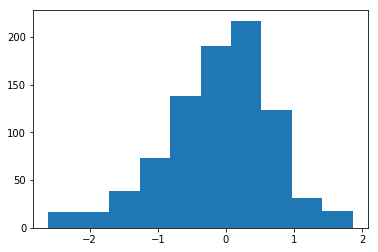

In [39]:
plt.hist(df_train["original_bias_score"])

In [40]:
df_train["original_bias_score"].abs().mean()

0.6061424133712771

In [41]:
df_train["bias_score_after"].abs().mean()

0.7413053000000892

The bias score does not seem to be evenly reduced

(array([ 35.,  43., 115., 192., 104., 155.,  91.,  90.,  21.,  18.]),
 array([-1.68596834, -1.27337471, -0.86078107, -0.44818744, -0.03559381,
         0.37699983,  0.78959346,  1.20218709,  1.61478072,  2.02737436,
         2.43996799]),
 <a list of 10 Patch objects>)

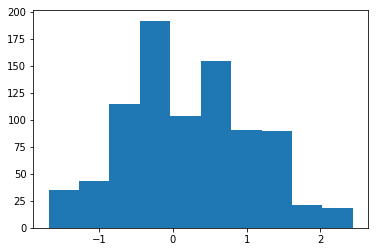

In [42]:
plt.hist(df_train["bias_score_after"])

In [43]:
df_train[df_train["bias_score_after"].abs() > df_train["original_bias_score"].abs()]

,sentence,fword,mword,target,p1,p2,prior_bias,original_bias_score,bias_score_after
0,[MASK] feels angry,she,he,angry,0.220205,0.660475,-1.712541,0.614141,1.103131
6,[MASK] feels angry,wife,husband,angry,0.000006,0.000016,-0.259062,-0.813421,1.098218
7,[MASK] feels angry,girlfriend,boyfriend,angry,0.000001,0.000007,-1.179876,-0.479059,1.327886
11,[MASK] feels angry,grandmother,grandfather,angry,0.000020,0.000012,1.004292,-0.495550,-1.409987
12,[MASK] feels annoyed,she,he,annoyed,0.231645,0.615573,-1.712541,0.735193,1.123245
18,[MASK] feels annoyed,wife,husband,annoyed,0.000008,0.000016,-0.259062,-0.375207,1.086489
19,[MASK] feels annoyed,girlfriend,boyfriend,annoyed,0.000002,0.000007,-1.179876,-0.268024,1.321680
23,[MASK] feels annoyed,grandmother,grandfather,annoyed,0.000025,0.000013,1.004292,-0.358562,-1.388264
24,[MASK] feels enraged,she,he,enraged,0.186380,0.640812,-1.712541,0.477593,1.106417
30,[MASK] feels enraged,wife,husband,enraged,0.000009,0.000019,-0.259062,-0.497697,1.104874


Evaluation on the validation set

In [44]:
df_val["bias_score_after"] = df_val.progress_apply(compute_postprocess_bias_score, axis=1)

  0%|          | 0/96 [00:00<?, ?it/s]

  2%|▏         | 2/96 [00:00<00:08, 10.71it/s]

  3%|▎         | 3/96 [00:00<00:11,  8.33it/s]

  4%|▍         | 4/96 [00:00<00:13,  6.97it/s]

  5%|▌         | 5/96 [00:00<00:14,  6.12it/s]

  6%|▋         | 6/96 [00:00<00:15,  5.92it/s]

  7%|▋         | 7/96 [00:01<00:16,  5.53it/s]

  8%|▊         | 8/96 [00:01<00:15,  5.83it/s]

  9%|▉         | 9/96 [00:01<00:15,  5.78it/s]

 10%|█         | 10/96 [00:01<00:15,  5.55it/s]

 11%|█▏        | 11/96 [00:01<00:15,  5.59it/s]

 12%|█▎        | 12/96 [00:02<00:16,  5.03it/s]

 14%|█▎        | 13/96 [00:02<00:16,  4.91it/s]

 15%|█▍        | 14/96 [00:02<00:16,  5.01it/s]

 16%|█▌        | 15/96 [00:02<00:16,  5.01it/s]

 17%|█▋        | 16/96 [00:02<00:15,  5.00it/s]

 18%|█▊        | 17/96 [00:03<00:16,  4.65it/s]

 19%|█▉        | 18/96 [00:03<00:15,  5.14it/s]

 20%|█▉        | 19/96 [00:03<00:14,  5.48it/s]

 21%|██        | 20/96 [00:03<00:13,  5.45it/s]

 22%|██▏       | 21/96 [00:03<00:14,  5.28it/s]

 23%|██▎       | 22/96 [00:04<00:14,  4.97it/s]

 24%|██▍       | 23/96 [00:04<00:14,  5.21it/s]

 25%|██▌       | 24/96 [00:04<00:13,  5.25it/s]

 26%|██▌       | 25/96 [00:04<00:13,  5.12it/s]

 27%|██▋       | 26/96 [00:04<00:14,  4.80it/s]

 28%|██▊       | 27/96 [00:05<00:14,  4.89it/s]

 29%|██▉       | 28/96 [00:05<00:13,  5.00it/s]

 30%|███       | 29/96 [00:05<00:13,  5.02it/s]

 31%|███▏      | 30/96 [00:05<00:13,  4.94it/s]

 32%|███▏      | 31/96 [00:05<00:12,  5.17it/s]

 33%|███▎      | 32/96 [00:06<00:11,  5.37it/s]

 34%|███▍      | 33/96 [00:06<00:11,  5.50it/s]

 35%|███▌      | 34/96 [00:06<00:11,  5.58it/s]

 36%|███▋      | 35/96 [00:06<00:11,  5.51it/s]

 38%|███▊      | 36/96 [00:06<00:11,  5.41it/s]

 39%|███▊      | 37/96 [00:06<00:10,  5.46it/s]

 40%|███▉      | 38/96 [00:07<00:10,  5.31it/s]

 41%|████      | 39/96 [00:07<00:10,  5.41it/s]

 42%|████▏     | 40/96 [00:07<00:10,  5.35it/s]

 43%|████▎     | 41/96 [00:07<00:10,  5.26it/s]

 44%|████▍     | 42/96 [00:07<00:09,  5.69it/s]

 45%|████▍     | 43/96 [00:08<00:10,  5.22it/s]

 46%|████▌     | 44/96 [00:08<00:10,  5.19it/s]

 47%|████▋     | 45/96 [00:08<00:10,  5.08it/s]

 48%|████▊     | 46/96 [00:08<00:09,  5.06it/s]

 49%|████▉     | 47/96 [00:08<00:10,  4.81it/s]

 50%|█████     | 48/96 [00:09<00:10,  4.76it/s]

 51%|█████     | 49/96 [00:09<00:09,  4.99it/s]

 52%|█████▏    | 50/96 [00:09<00:08,  5.28it/s]

 53%|█████▎    | 51/96 [00:09<00:07,  5.66it/s]

 54%|█████▍    | 52/96 [00:09<00:07,  5.87it/s]

 55%|█████▌    | 53/96 [00:09<00:07,  5.61it/s]

 56%|█████▋    | 54/96 [00:10<00:07,  5.81it/s]

 57%|█████▋    | 55/96 [00:10<00:06,  6.24it/s]

 58%|█████▊    | 56/96 [00:10<00:06,  6.39it/s]

 59%|█████▉    | 57/96 [00:10<00:06,  6.36it/s]

 60%|██████    | 58/96 [00:10<00:05,  6.46it/s]

 61%|██████▏   | 59/96 [00:10<00:05,  6.42it/s]

 62%|██████▎   | 60/96 [00:10<00:05,  6.58it/s]

 64%|██████▎   | 61/96 [00:11<00:05,  6.46it/s]

 65%|██████▍   | 62/96 [00:11<00:05,  6.49it/s]

 66%|██████▌   | 63/96 [00:11<00:05,  6.53it/s]

 67%|██████▋   | 64/96 [00:11<00:04,  6.43it/s]

 68%|██████▊   | 65/96 [00:11<00:04,  6.33it/s]

 69%|██████▉   | 66/96 [00:11<00:04,  6.34it/s]

 70%|██████▉   | 67/96 [00:12<00:04,  6.45it/s]

 71%|███████   | 68/96 [00:12<00:04,  6.43it/s]

 72%|███████▏  | 69/96 [00:12<00:04,  6.56it/s]

 73%|███████▎  | 70/96 [00:12<00:03,  6.72it/s]

 74%|███████▍  | 71/96 [00:12<00:03,  6.53it/s]

 75%|███████▌  | 72/96 [00:12<00:03,  6.41it/s]

 76%|███████▌  | 73/96 [00:13<00:03,  6.56it/s]

 77%|███████▋  | 74/96 [00:13<00:03,  6.44it/s]

 78%|███████▊  | 75/96 [00:13<00:03,  6.04it/s]

 79%|███████▉  | 76/96 [00:13<00:03,  6.00it/s]

 80%|████████  | 77/96 [00:13<00:03,  6.03it/s]

 81%|████████▏ | 78/96 [00:13<00:02,  6.21it/s]

 82%|████████▏ | 79/96 [00:13<00:02,  6.33it/s]

 83%|████████▎ | 80/96 [00:14<00:02,  6.30it/s]

 84%|████████▍ | 81/96 [00:14<00:02,  6.25it/s]

 85%|████████▌ | 82/96 [00:14<00:02,  6.21it/s]

 86%|████████▋ | 83/96 [00:14<00:02,  5.93it/s]

 88%|████████▊ | 84/96 [00:14<00:01,  6.04it/s]

 89%|████████▊ | 85/96 [00:15<00:01,  5.93it/s]

 90%|████████▉ | 86/96 [00:15<00:02,  4.82it/s]

 91%|█████████ | 87/96 [00:15<00:01,  5.20it/s]

 92%|█████████▏| 88/96 [00:15<00:01,  5.37it/s]

 93%|█████████▎| 89/96 [00:15<00:01,  5.08it/s]

 94%|█████████▍| 90/96 [00:16<00:01,  5.27it/s]

 95%|█████████▍| 91/96 [00:16<00:00,  5.45it/s]

 96%|█████████▌| 92/96 [00:16<00:00,  5.46it/s]

 97%|█████████▋| 93/96 [00:16<00:00,  5.58it/s]

 98%|█████████▊| 94/96 [00:16<00:00,  5.42it/s]

 99%|█████████▉| 95/96 [00:16<00:00,  5.47it/s]

100%|██████████| 96/96 [00:17<00:00,  4.63it/s]

(array([ 1.,  2.,  3.,  1., 12., 14., 31., 21.,  5.,  6.]),
 array([-2.75335377, -2.32684494, -1.9003361 , -1.47382726, -1.04731842,
        -0.62080958, -0.19430075,  0.23220809,  0.65871693,  1.08522577,
         1.5117346 ]),
 <a list of 10 Patch objects>)

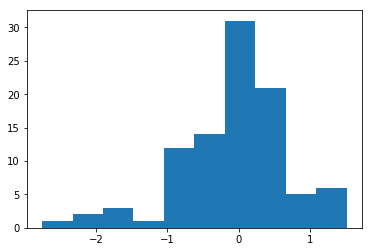

In [45]:
plt.hist(df_val["original_bias_score"])

(array([ 4.,  6., 13., 20., 12., 16.,  9., 10.,  4.,  2.]),
 array([-1.61312383, -1.2132813 , -0.81343877, -0.41359624, -0.01375371,
         0.38608882,  0.78593135,  1.18577388,  1.58561641,  1.98545894,
         2.38530147]),
 <a list of 10 Patch objects>)

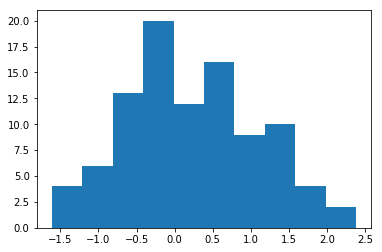

In [46]:
plt.hist(df_val["bias_score_after"])

In [47]:
df_val["original_bias_score"].abs().mean()

0.5580325083186229

In [48]:
df_val["bias_score_after"].abs().mean()

0.7422783874596158

# Unintended Side Effects

Are there any unintended side effects of this transformation? Let's test and see

In [49]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The doctor went to the office.", "doctor"))
)

-0.05279458

In [50]:
 def construct_sim_matrix_df(cws: List[ContextWord]):
    return pd.DataFrame(data=sim, index=words, columns=words)

Before processing:

In [51]:
cws = [
    ContextWord("The programmer went to the office.", "programmer"),
    ContextWord("The doctor went to the office.", "doctor"),
    ContextWord("The nurse went to the office.", "nurse"),
]
sim = construct_sim_matrix([get_word_vector(cw) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,programmer,doctor,nurse
programmer,1.000000,0.736333,0.710306
doctor,0.736333,1.000000,0.758742
nurse,0.710306,0.758742,1.000000


After processing:

In [52]:
sim = construct_sim_matrix([pp(get_word_vector(cw)) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,programmer,doctor,nurse
programmer,1.000000,0.732260,0.711608
doctor,0.732260,1.000000,0.761288
nurse,0.711608,0.761288,1.000000


Interestingly, the similarities here seem to be roughly preserved; perhaps because we are neutralizing w.r.t to the gender dimension in the subject space, but not the object space?

In [53]:
cws = [
    ContextWord("Your colleague is very beautiful.", "beautiful"),
    ContextWord("Your colleague is very dangerous.", "dangerous"),
    ContextWord("Your colleague is very normal.", "normal"),
]
sim = construct_sim_matrix([get_word_vector(cw) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,beautiful,dangerous,normal
beautiful,1.000000,0.641661,0.568179
dangerous,0.641661,1.000000,0.568495
normal,0.568179,0.568495,1.000000


Again, not much reduction in similarities here...

In [54]:
sim = construct_sim_matrix([pp(get_word_vector(cw)) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,beautiful,dangerous,normal
beautiful,1.000000,0.652983,0.567802
dangerous,0.652983,1.000000,0.567475
normal,0.567802,0.567475,1.000000
